## Analysis of the results obtained by the models

In [49]:
from pathlib import Path
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.ticker as mticker
import re

import os

In [50]:
REPORTS_DIRECTORY = Path("..") / "reports"
RESULTS_DIRECTORY = Path("..") / "results"
FIGURES_DIRECTORY = Path("..") / "figures" / "metrics"
FIGURES_DIRECTORY.mkdir(parents=True, exist_ok=True)

outputs = pd.read_pickle(RESULTS_DIRECTORY / "outputs_wp3_wp5.pkl") # blue, green, orange and pink columns
property_name_list = outputs.columns.tolist()
#property_name_list = ["Fungal Saprotrophs"] # to test code

metrics_name_list = 'R2 RMSE bias RPIQ MAE'.split()

target_cwt_coeff= 5

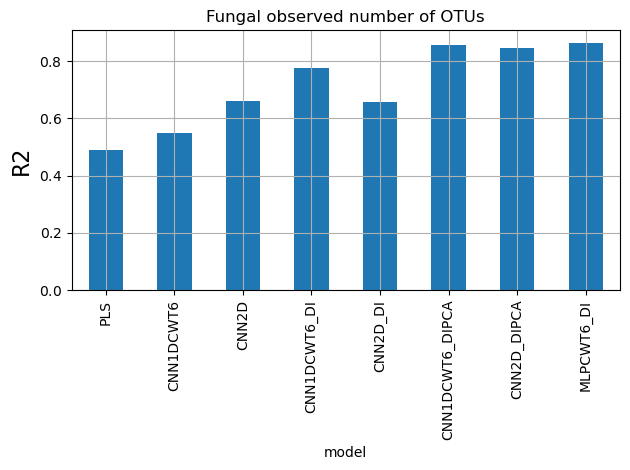

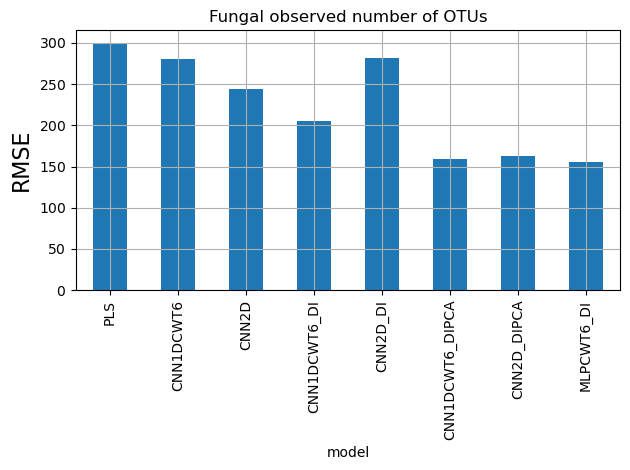

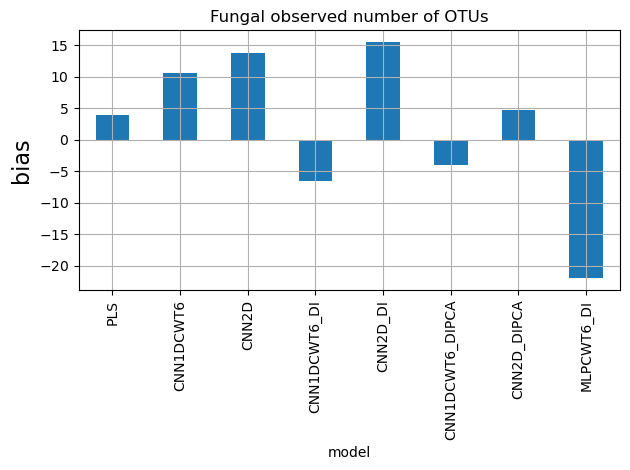

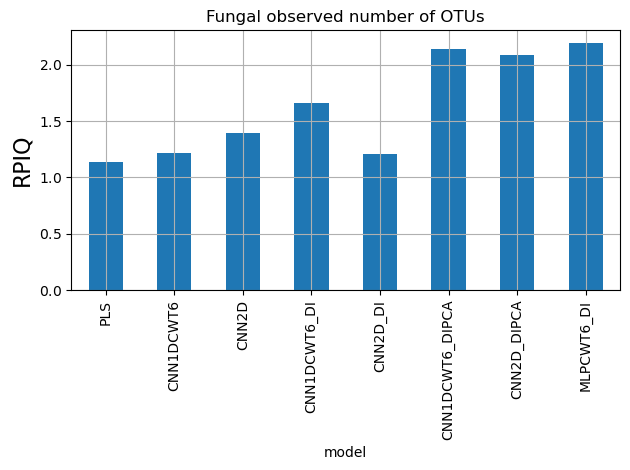

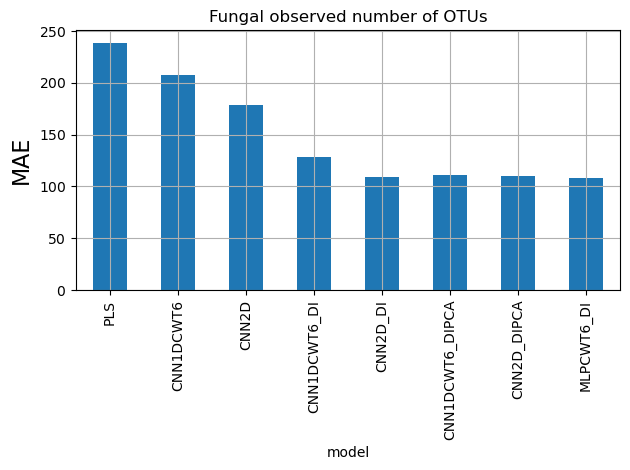

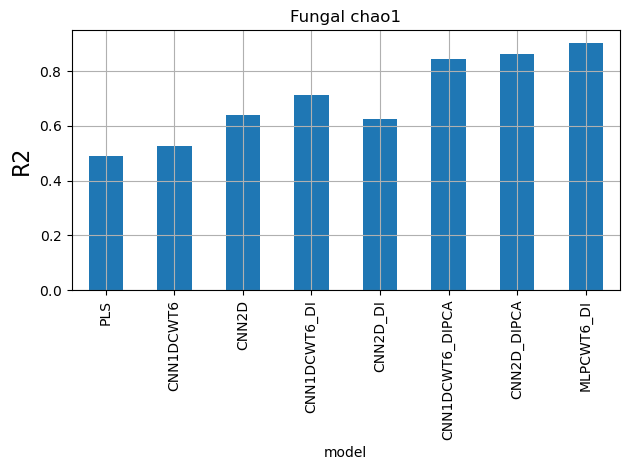

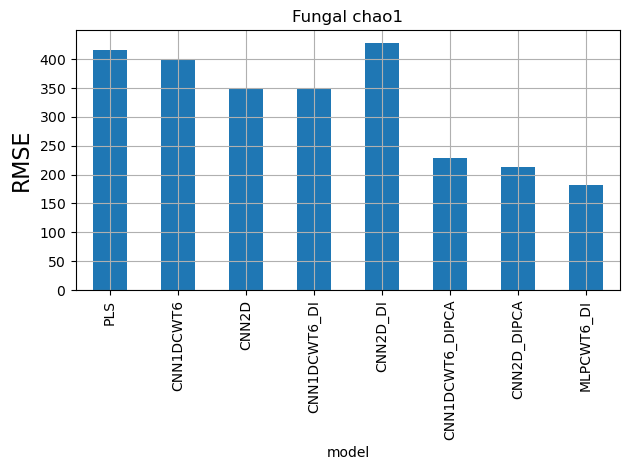

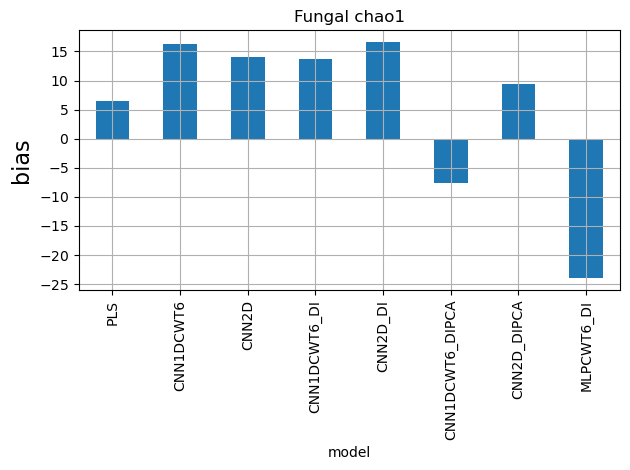

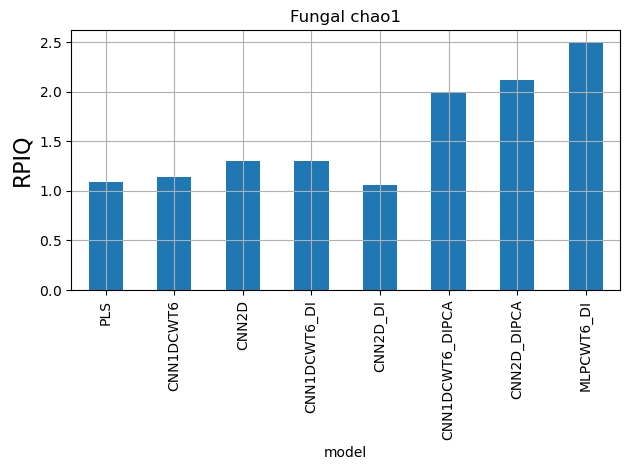

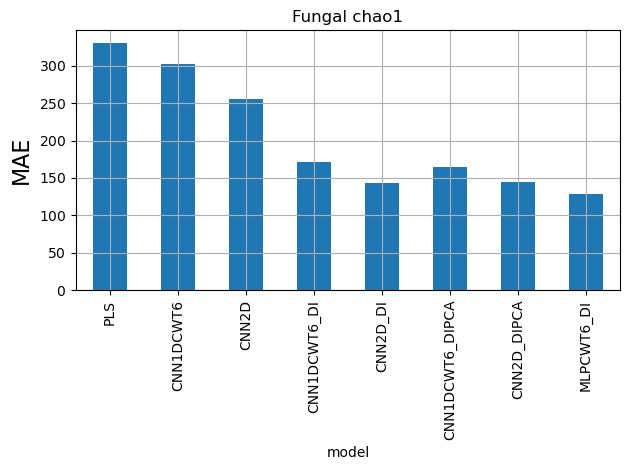

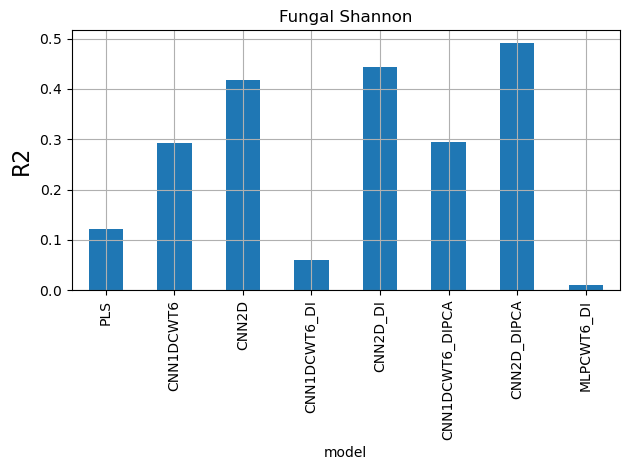

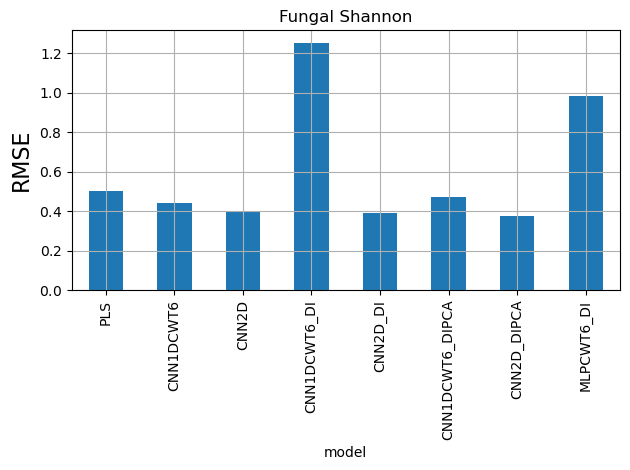

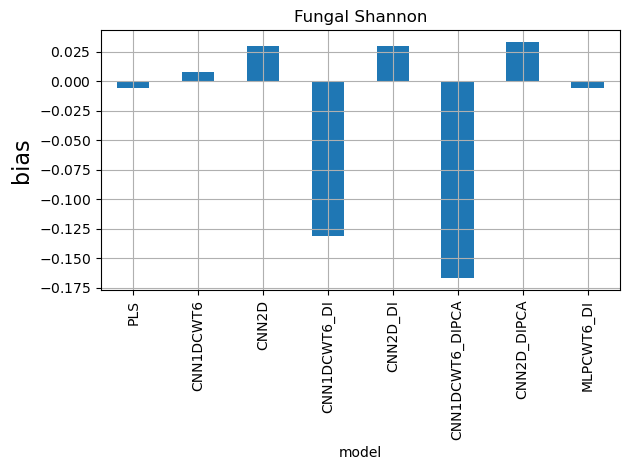

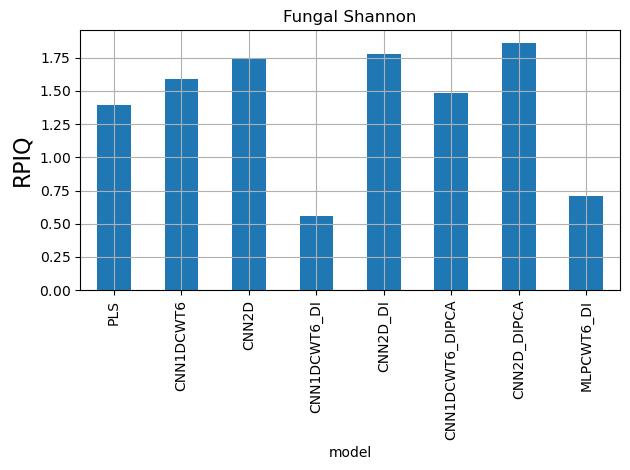

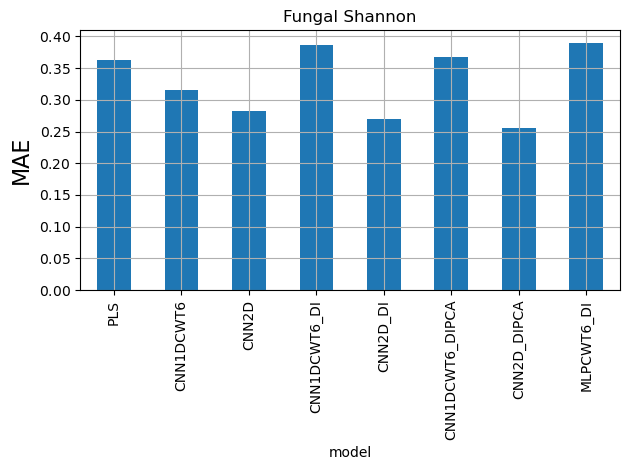

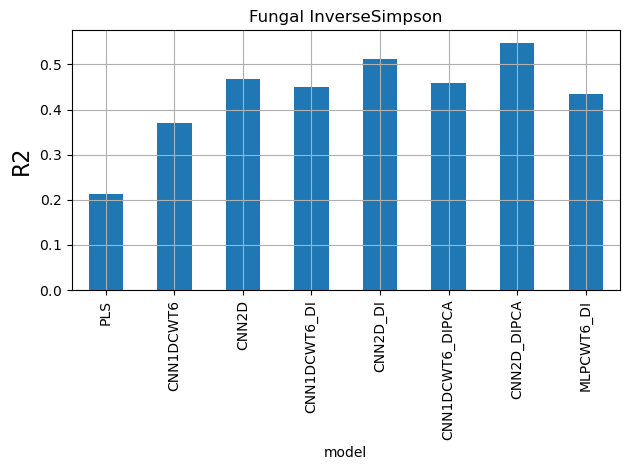

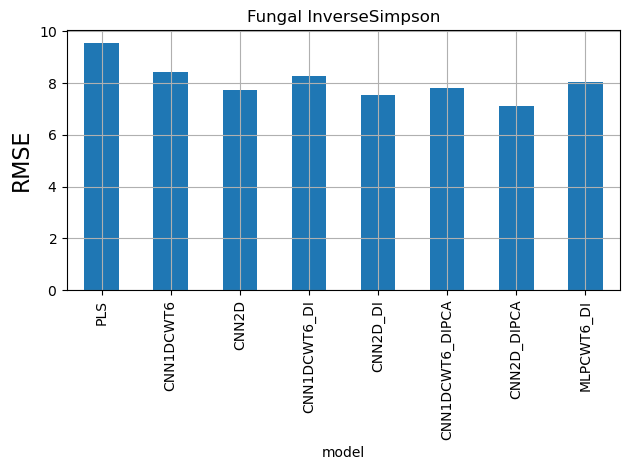

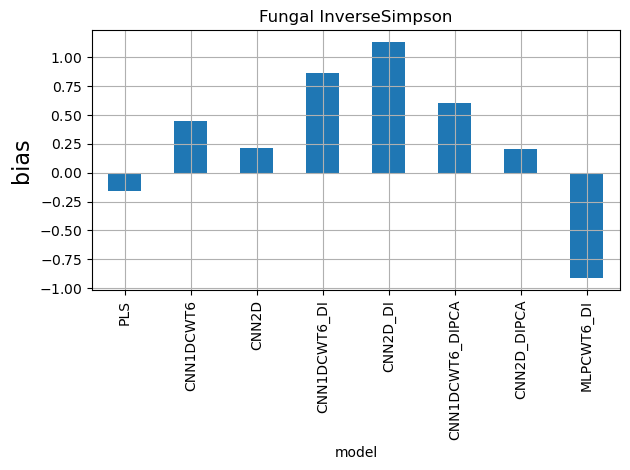

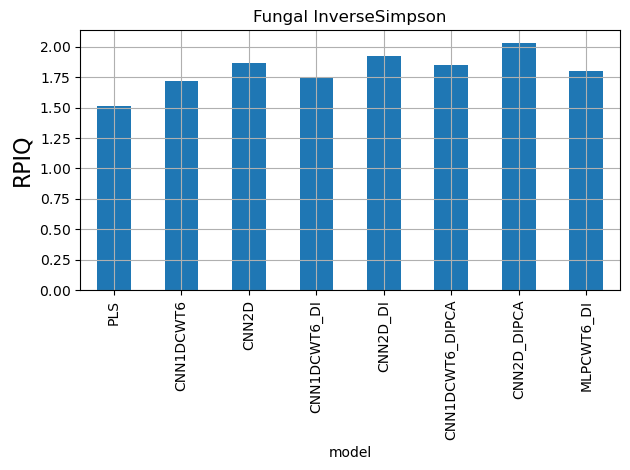

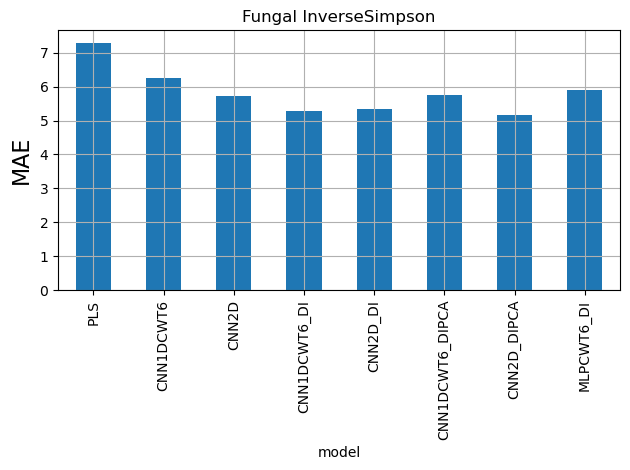

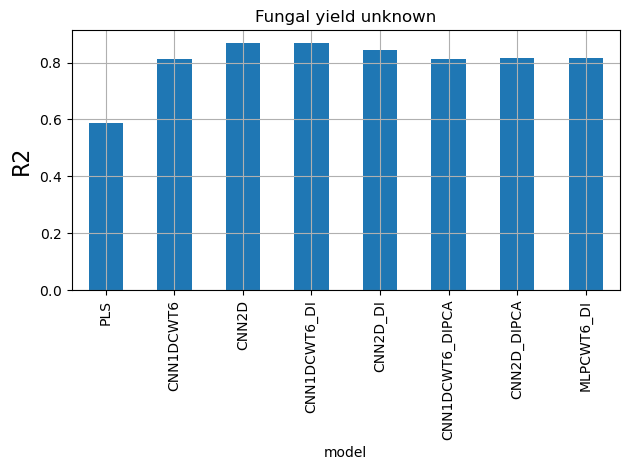

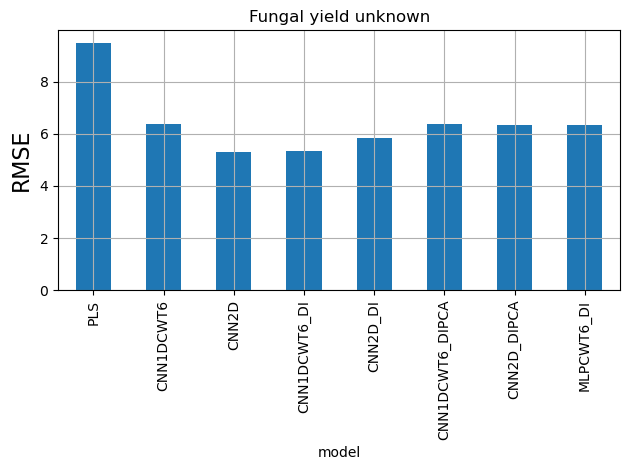

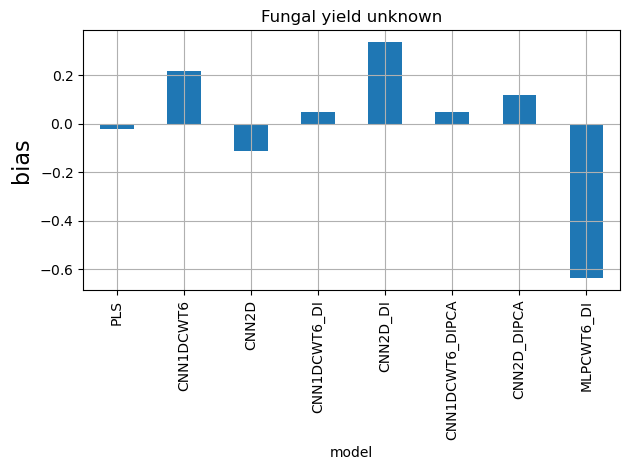

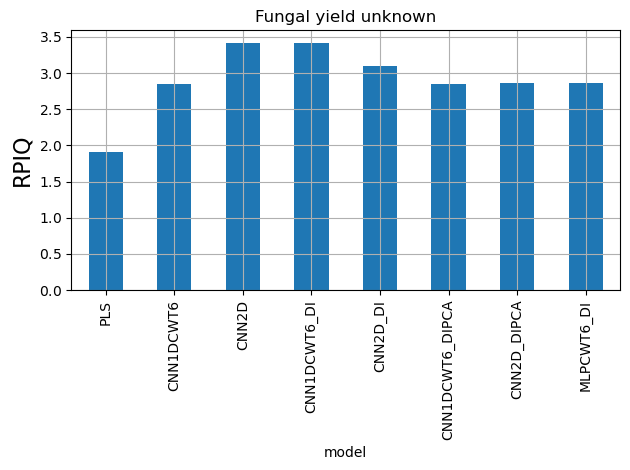

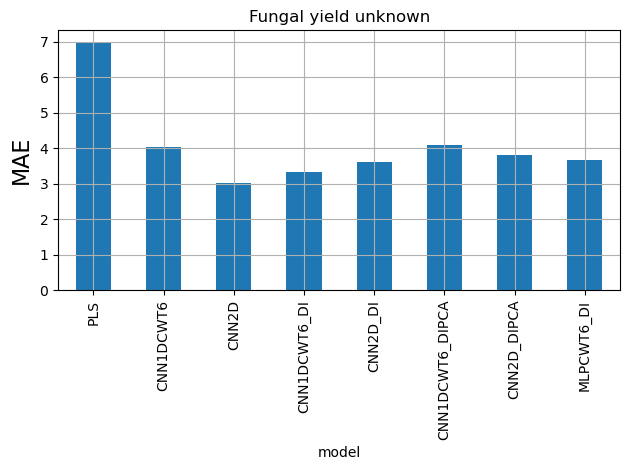

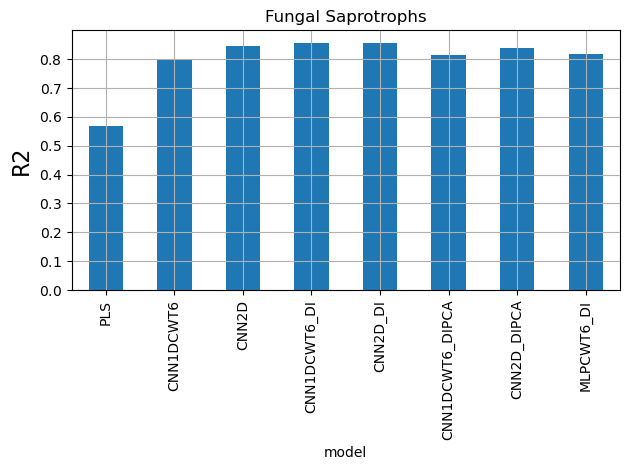

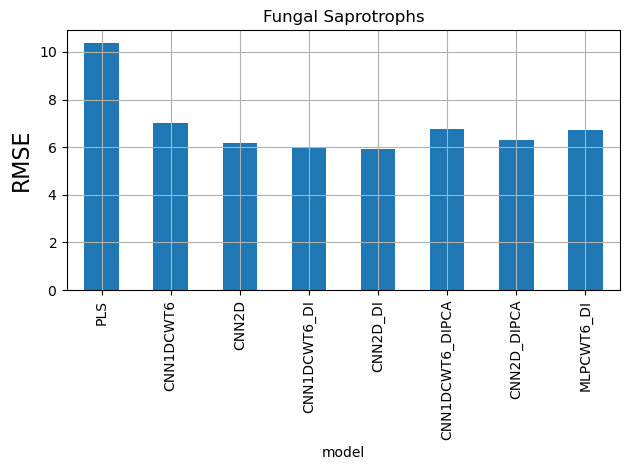

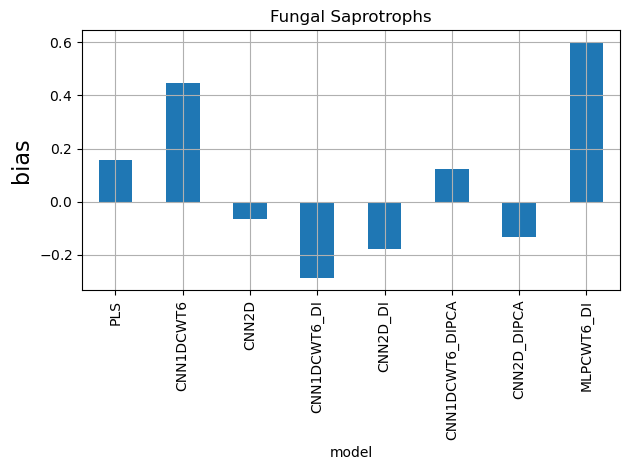

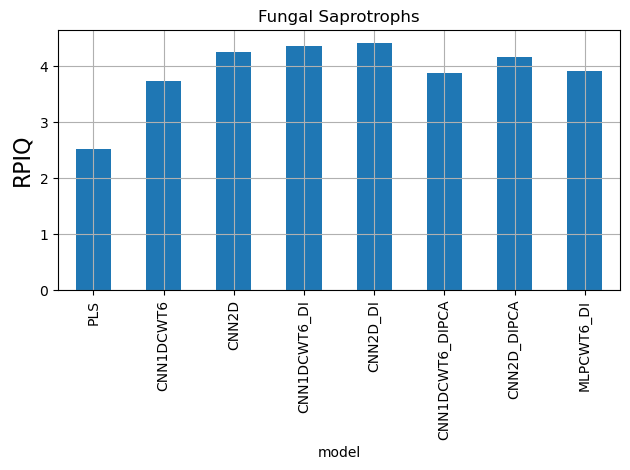

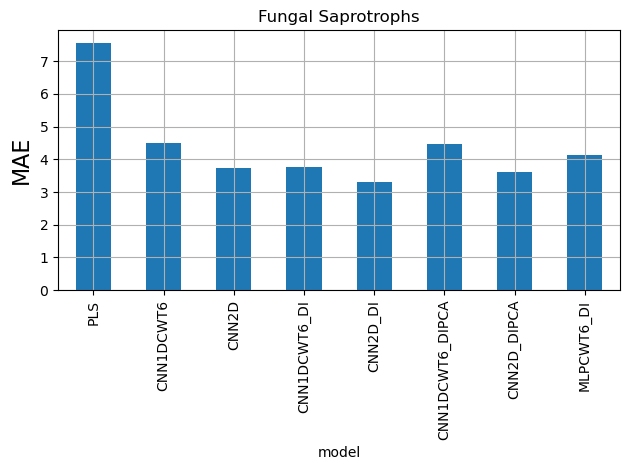

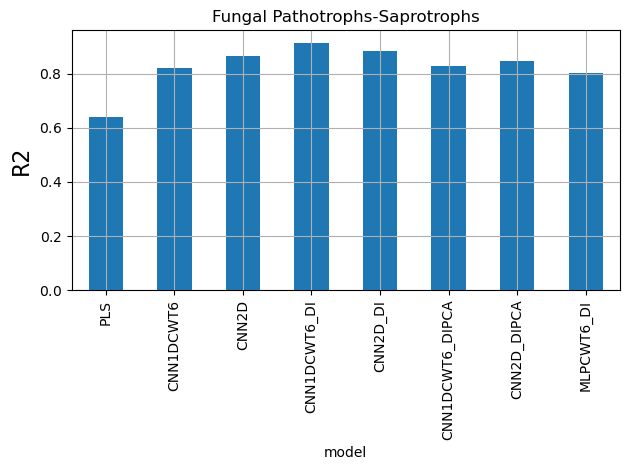

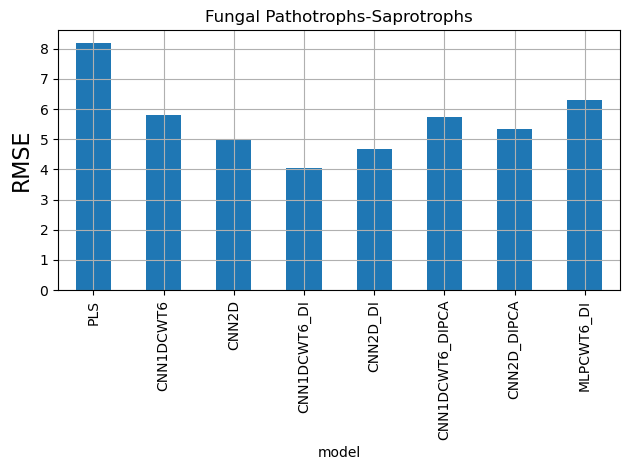

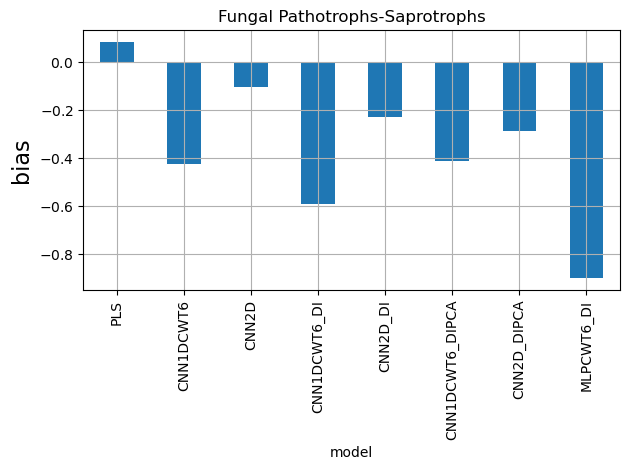

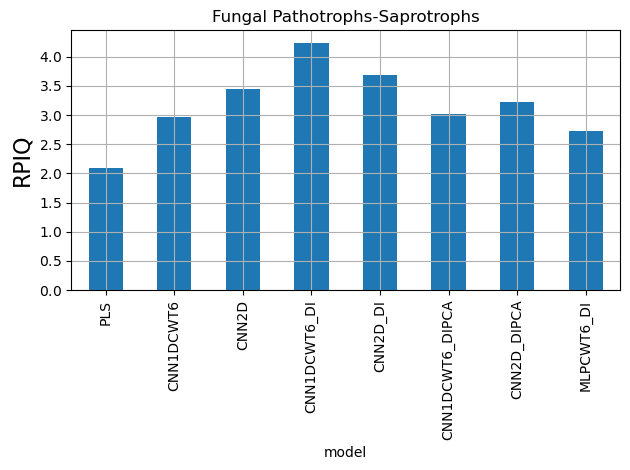

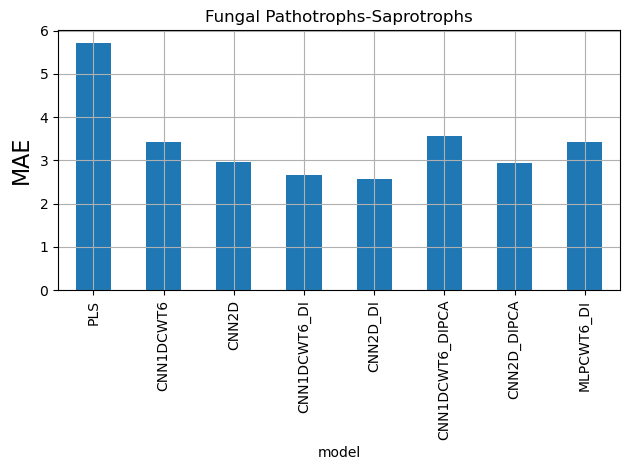

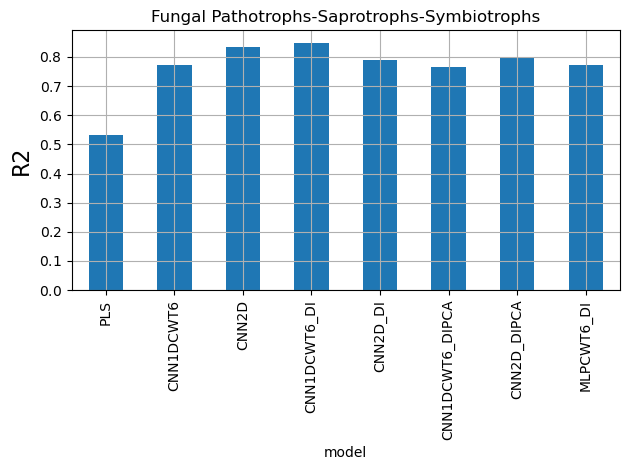

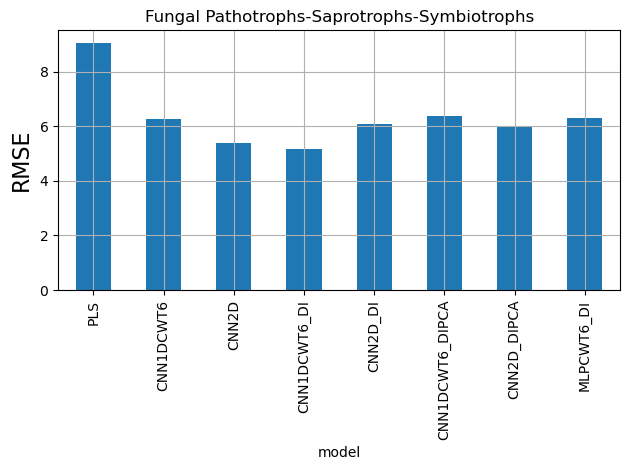

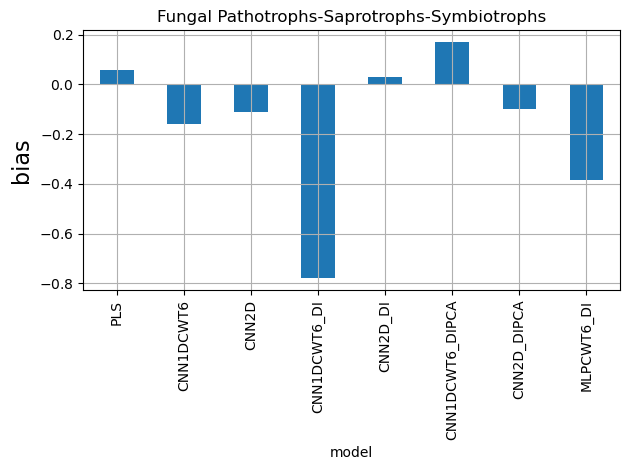

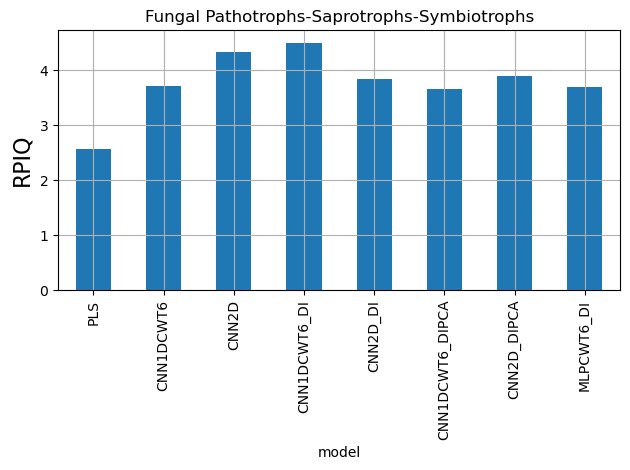

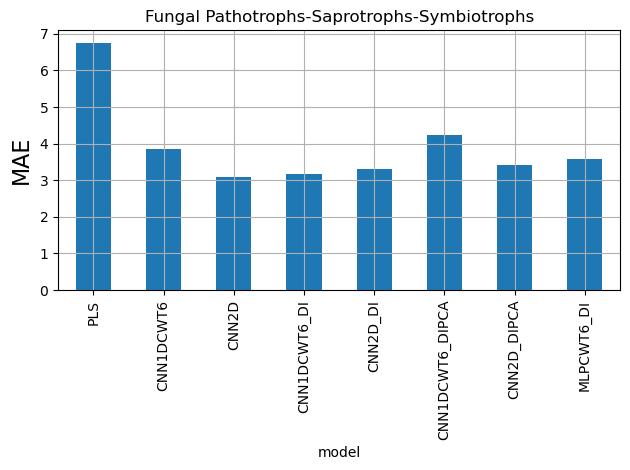

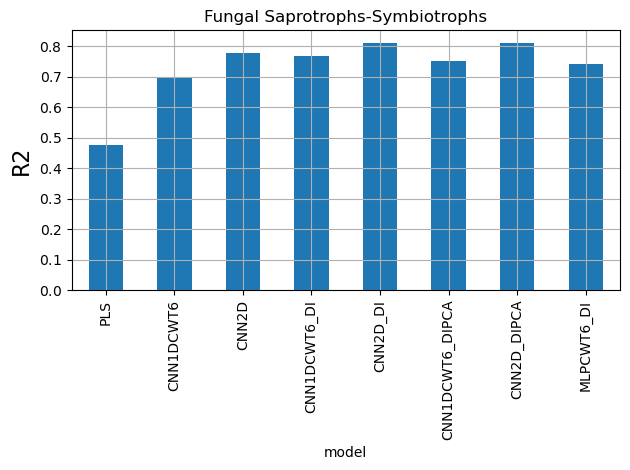

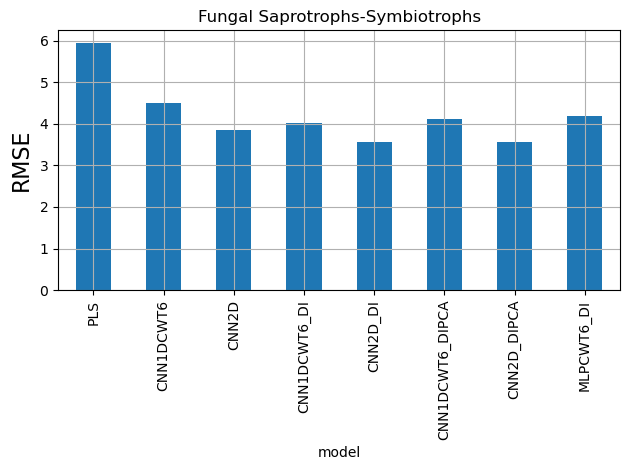

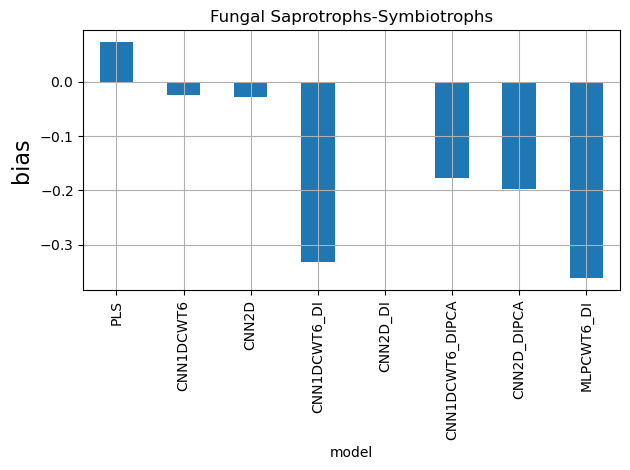

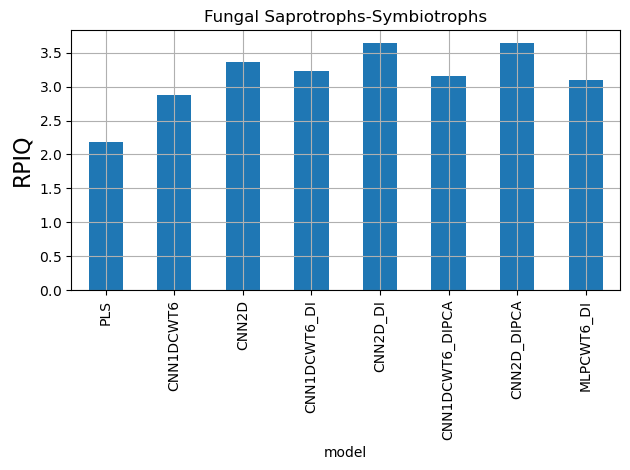

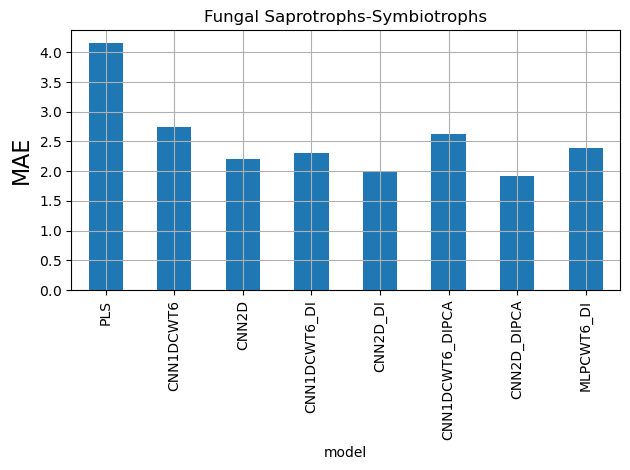

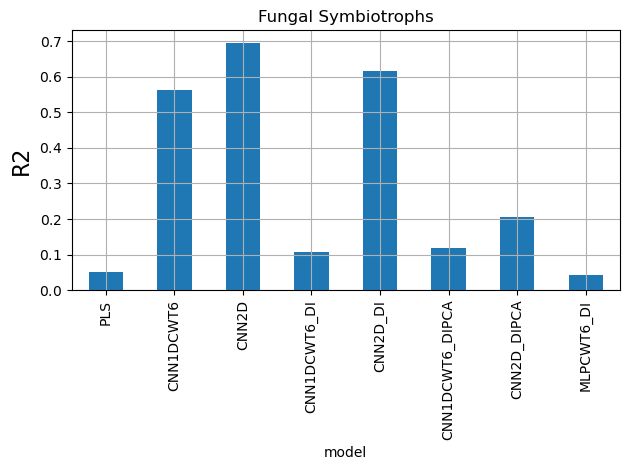

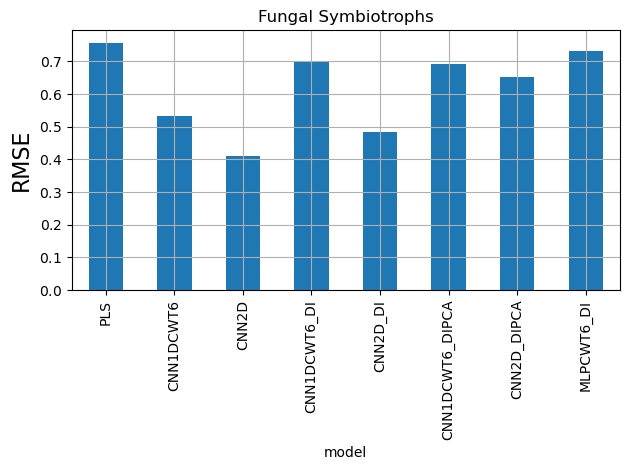

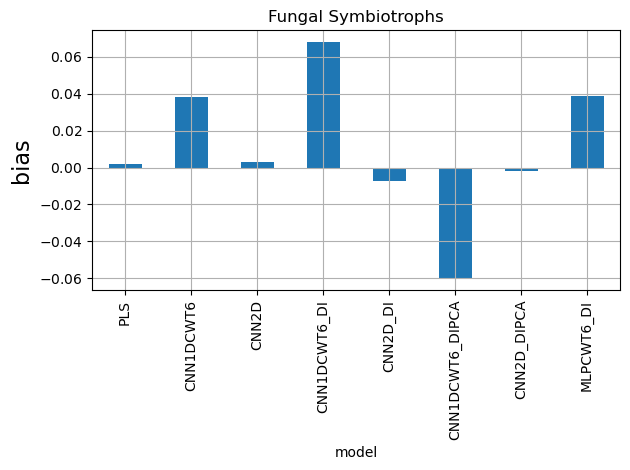

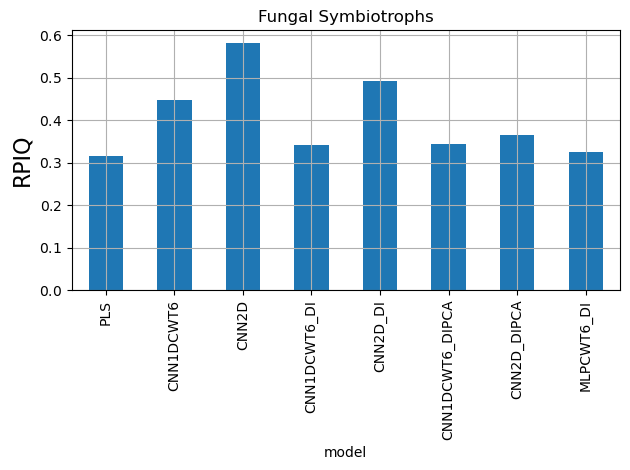

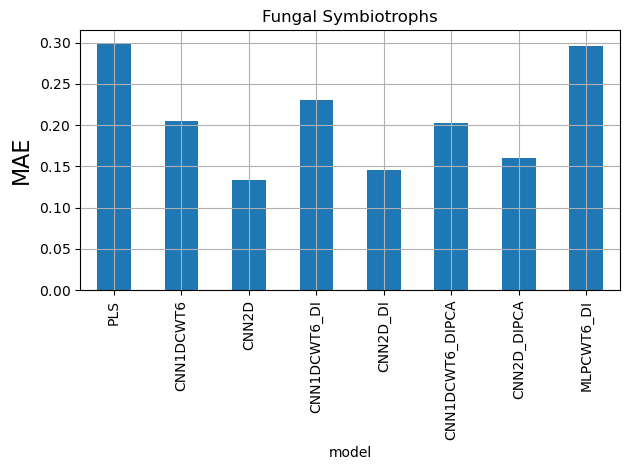

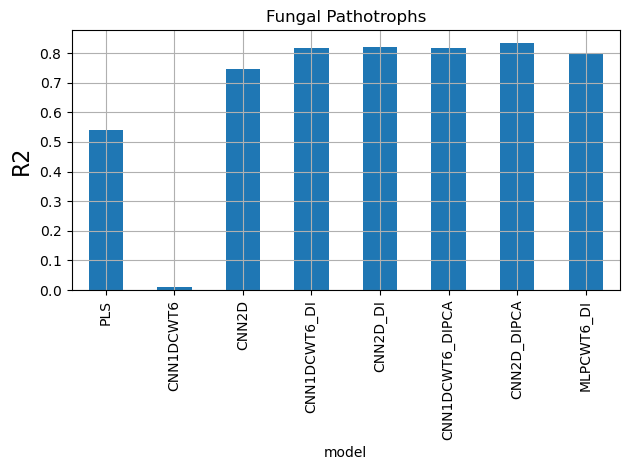

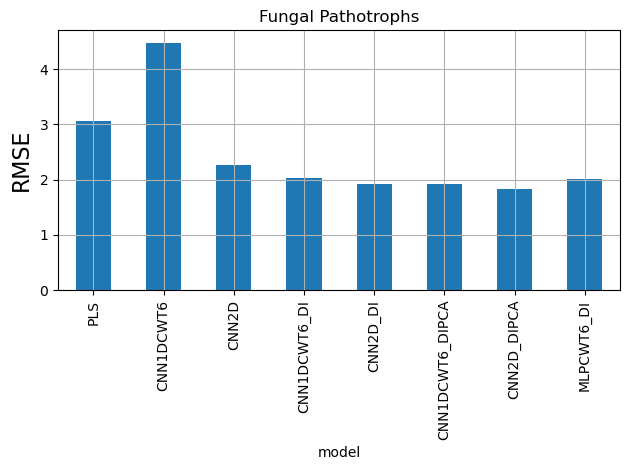

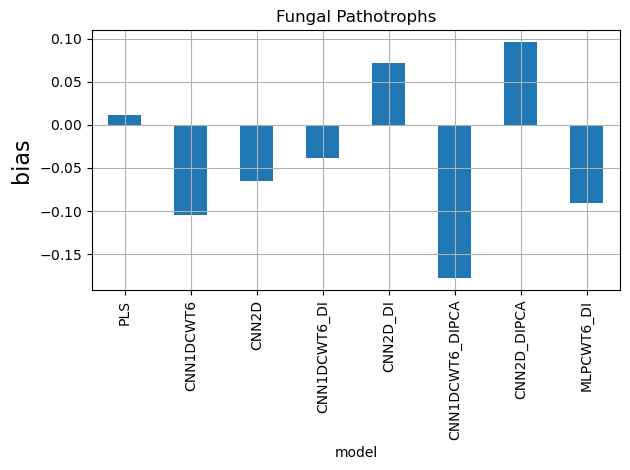

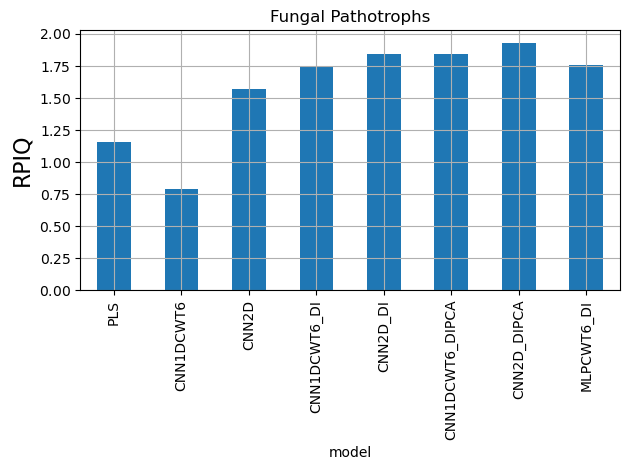

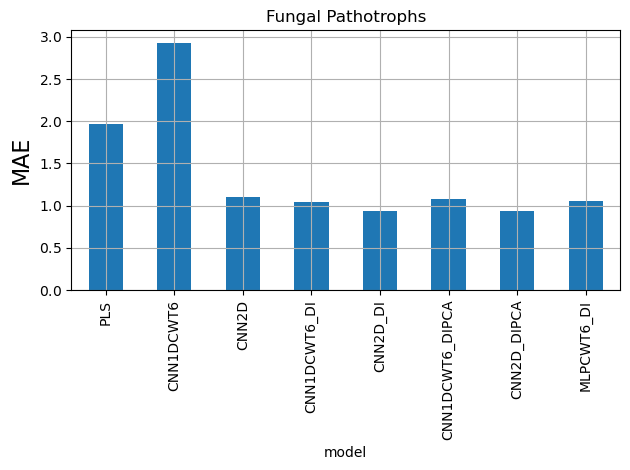

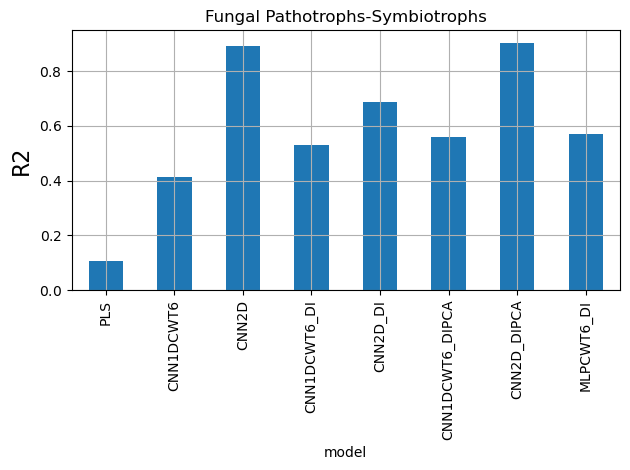

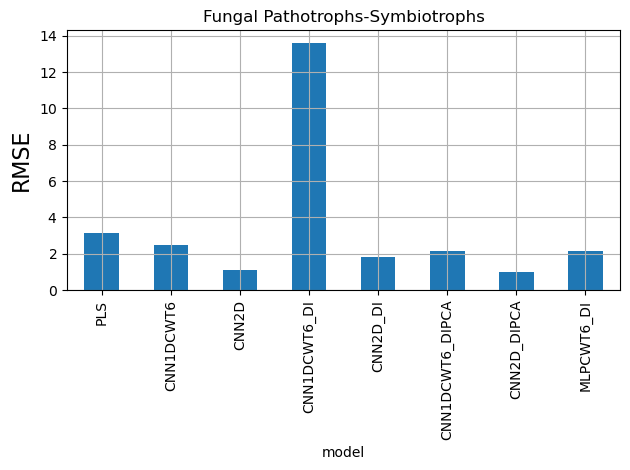

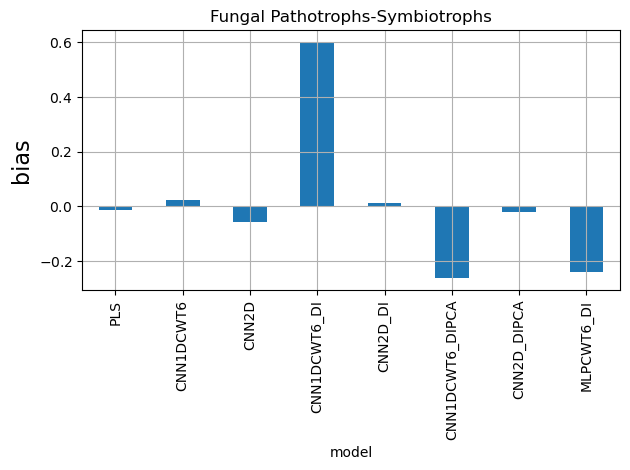

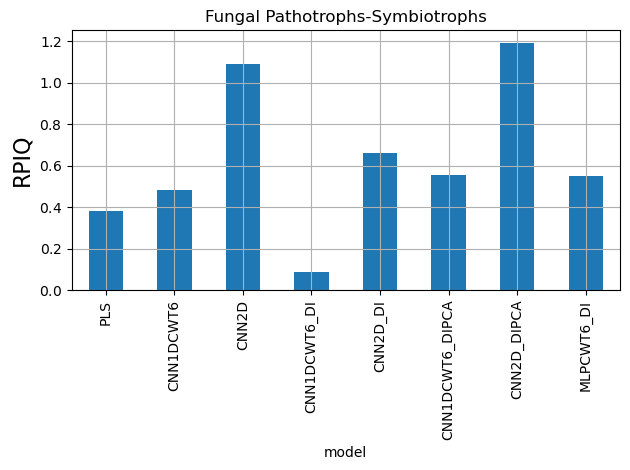

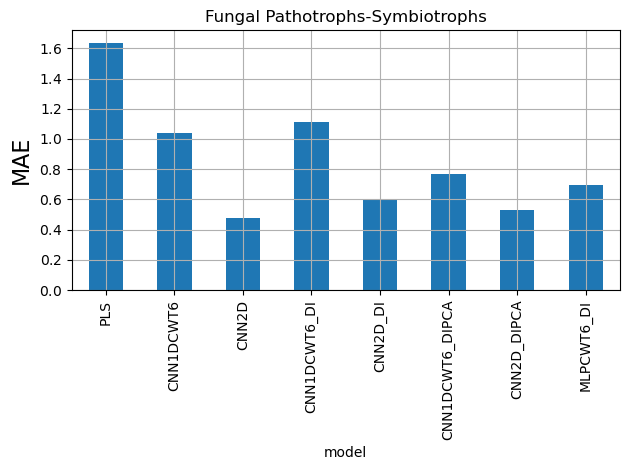

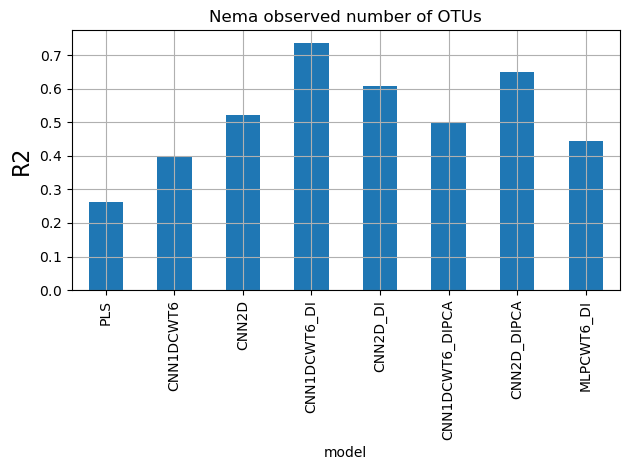

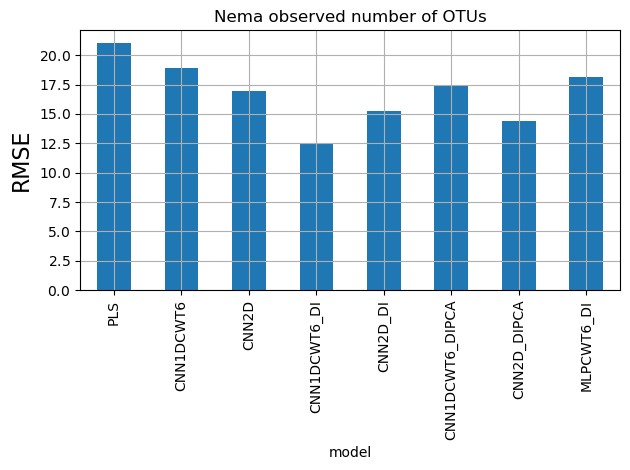

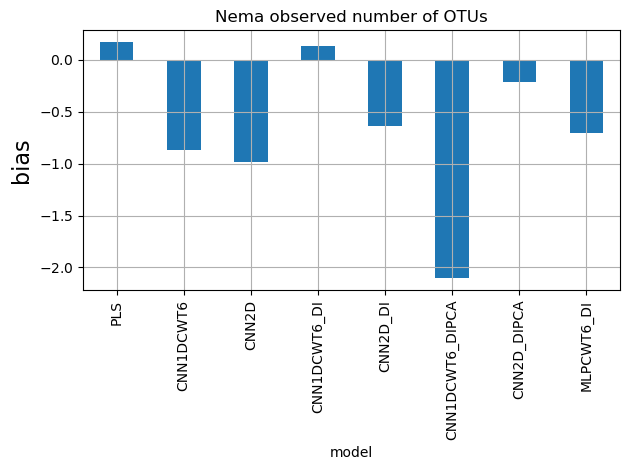

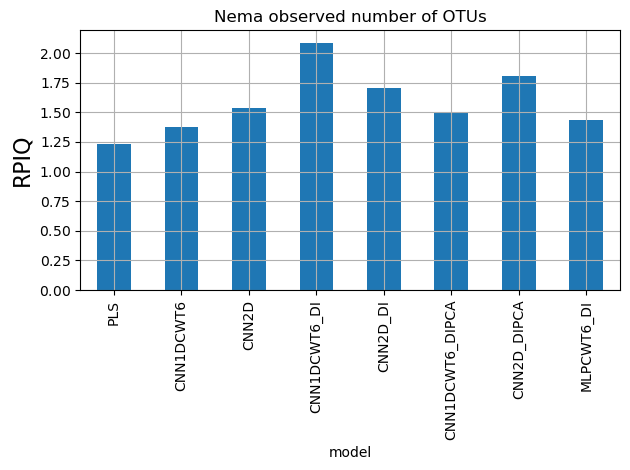

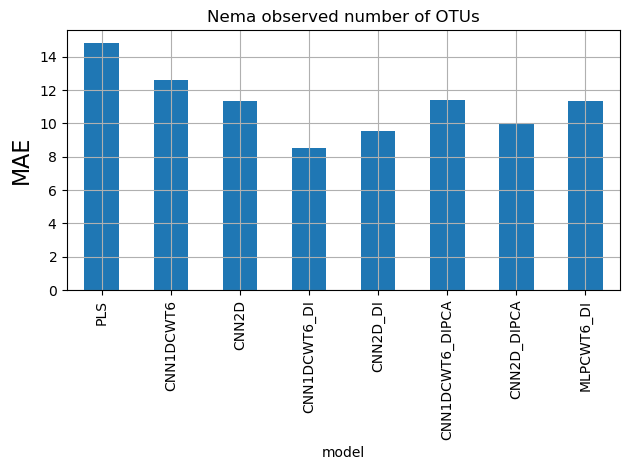

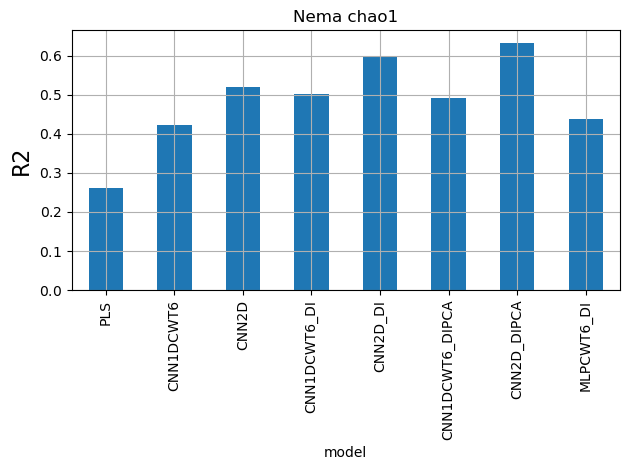

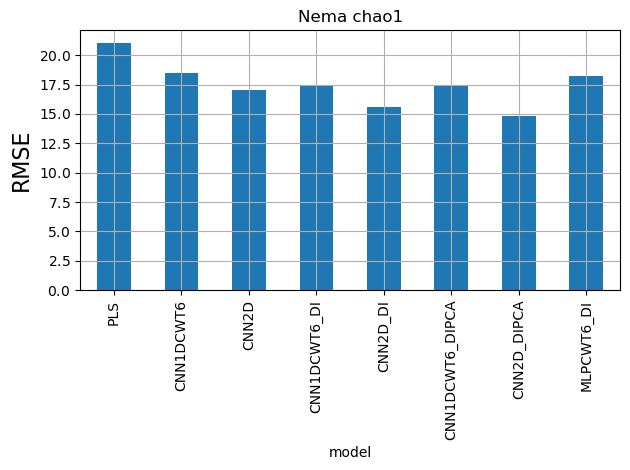

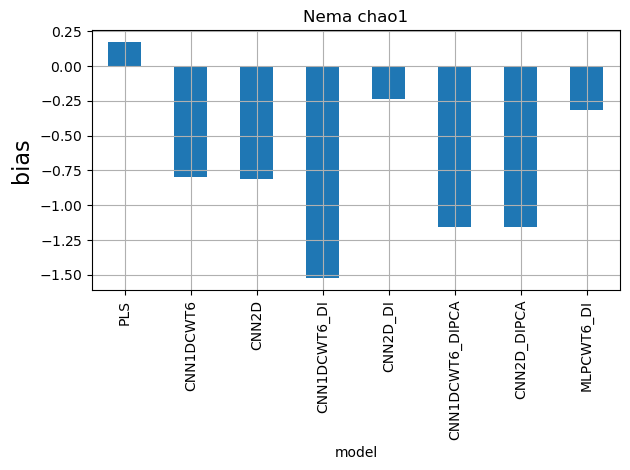

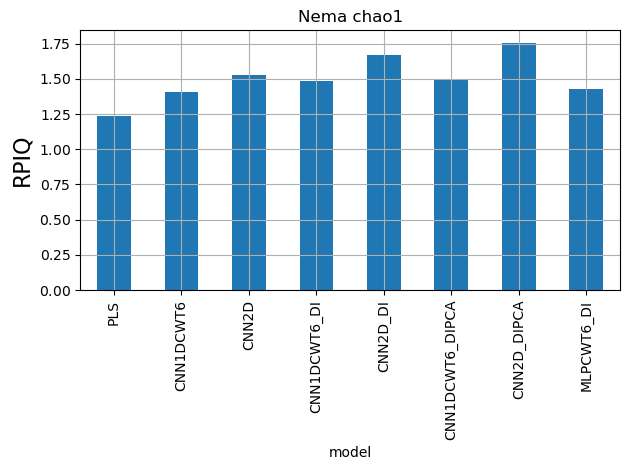

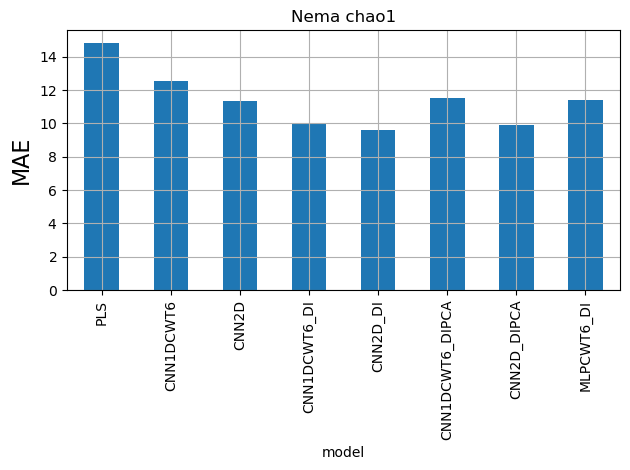

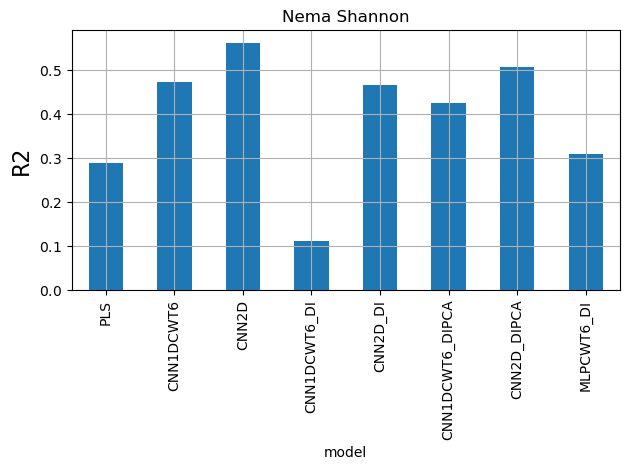

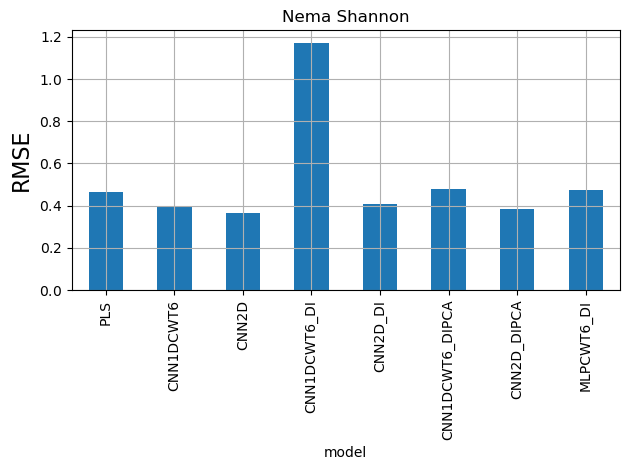

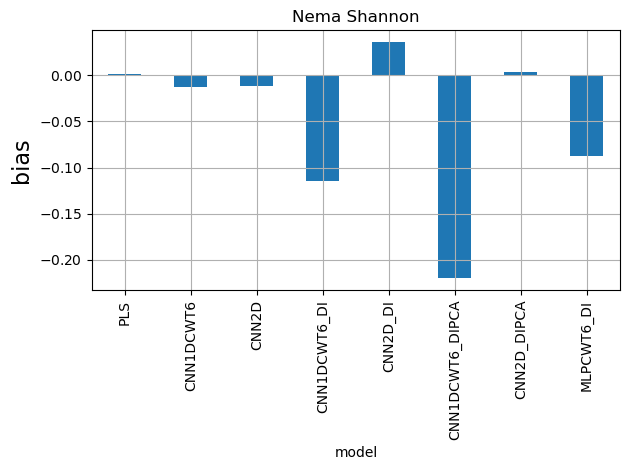

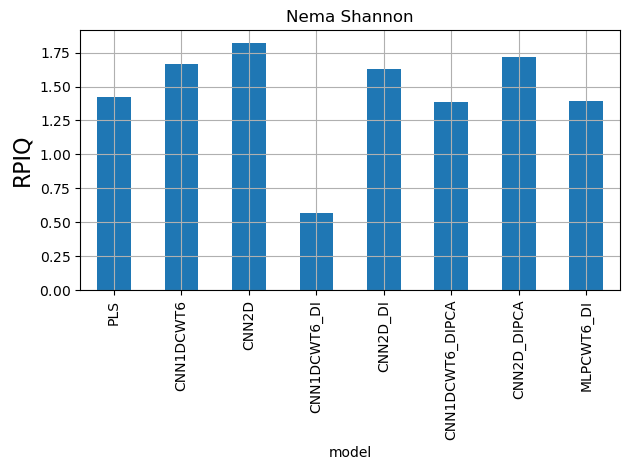

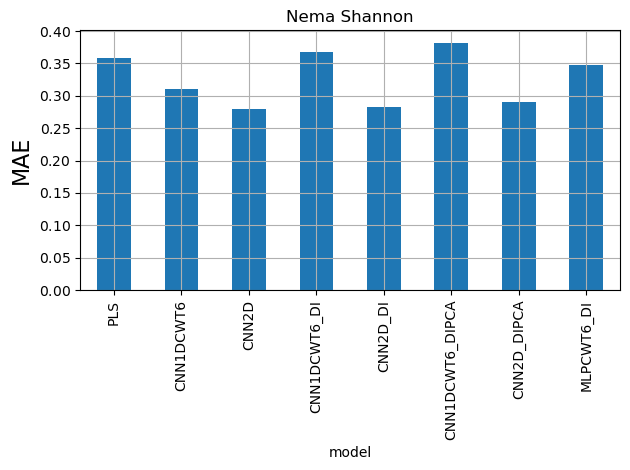

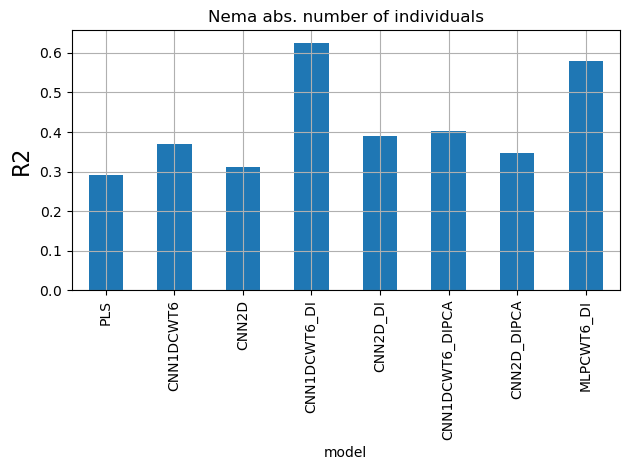

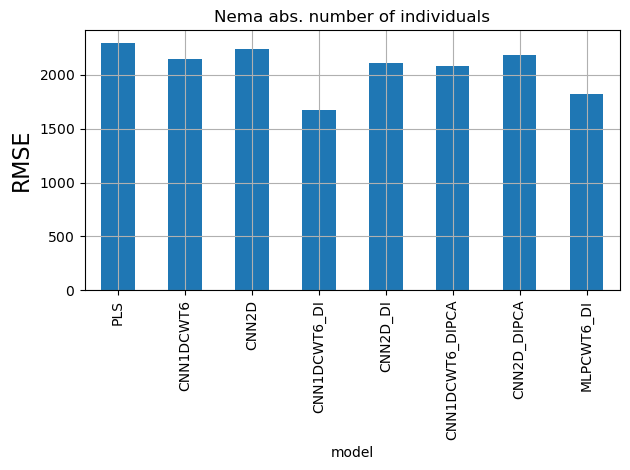

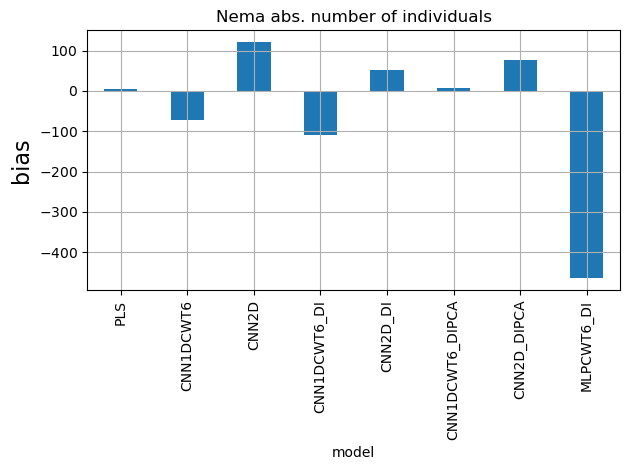

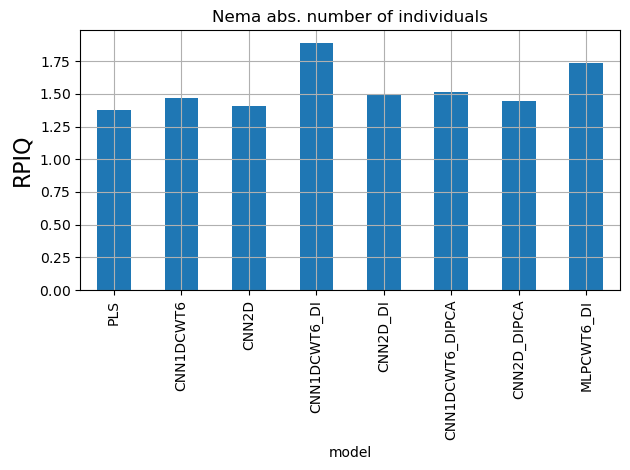

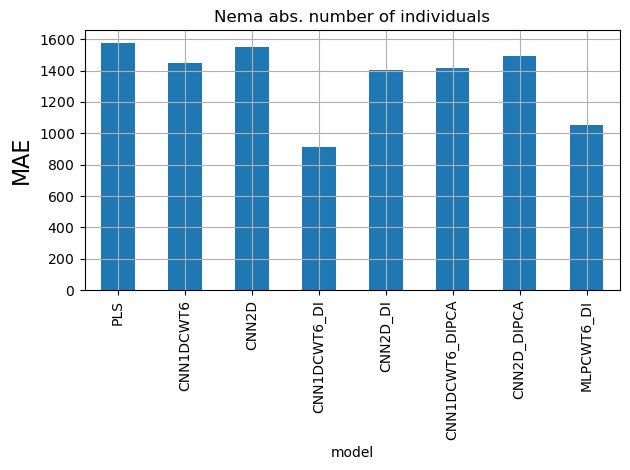

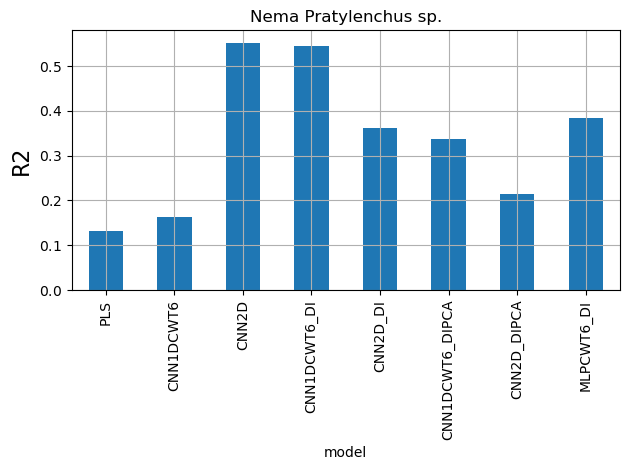

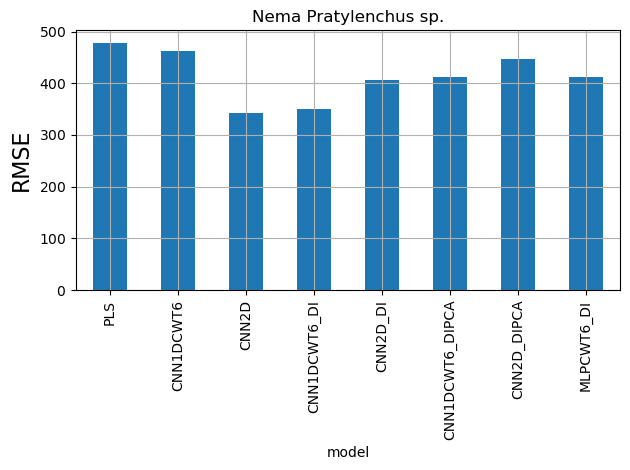

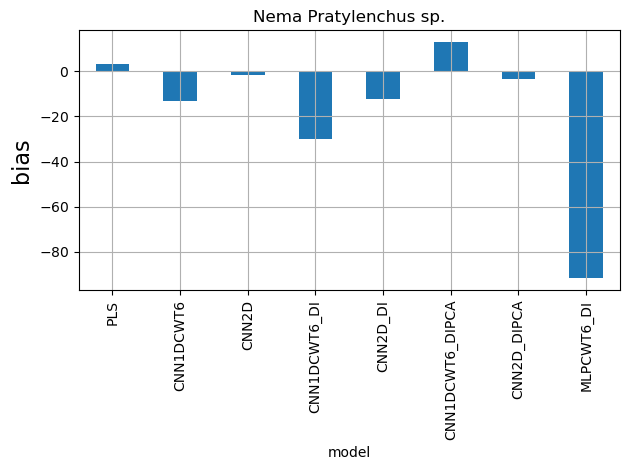

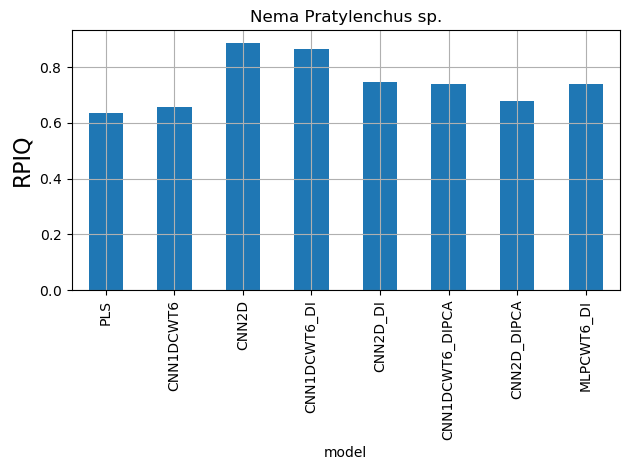

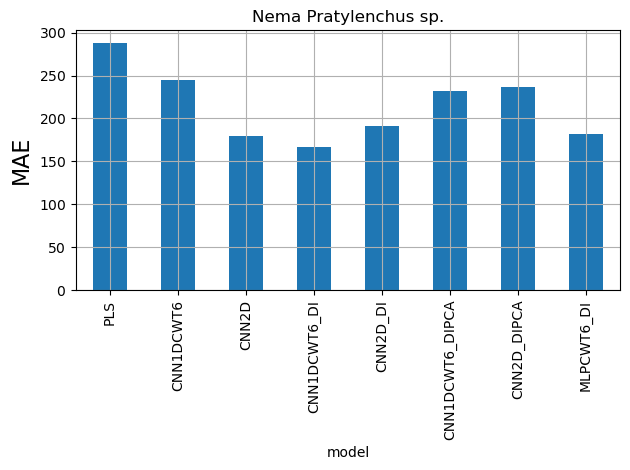

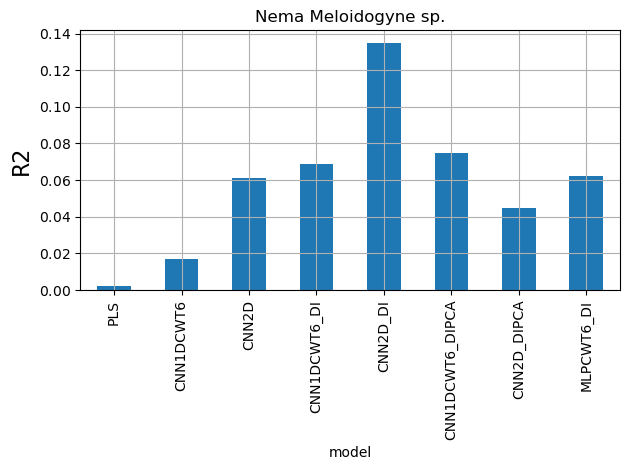

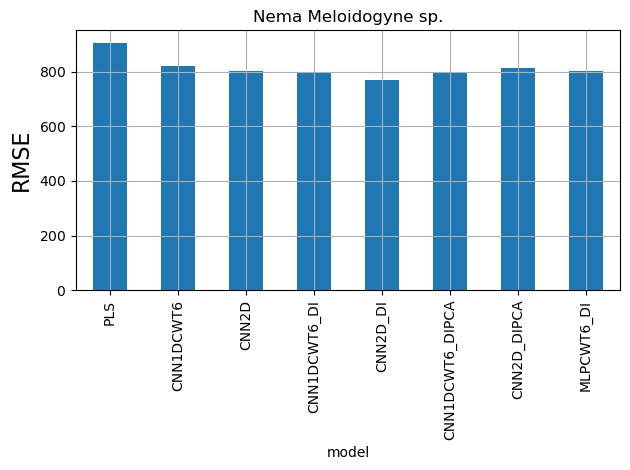

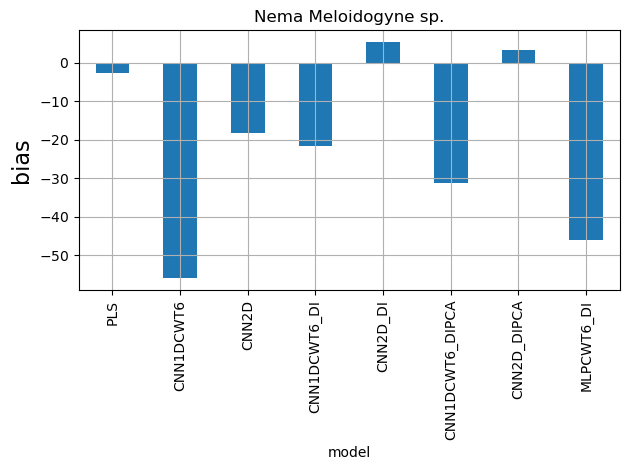

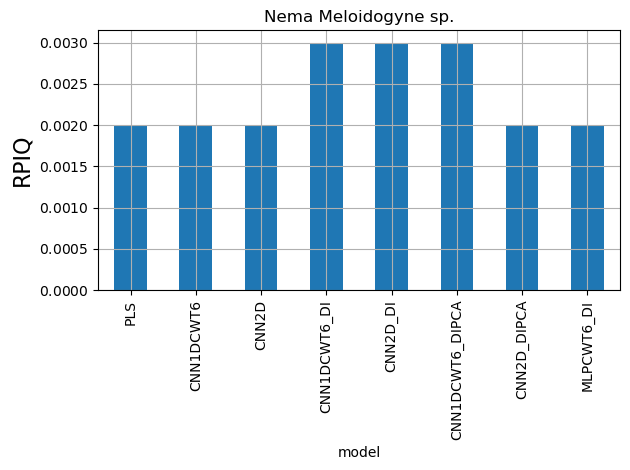

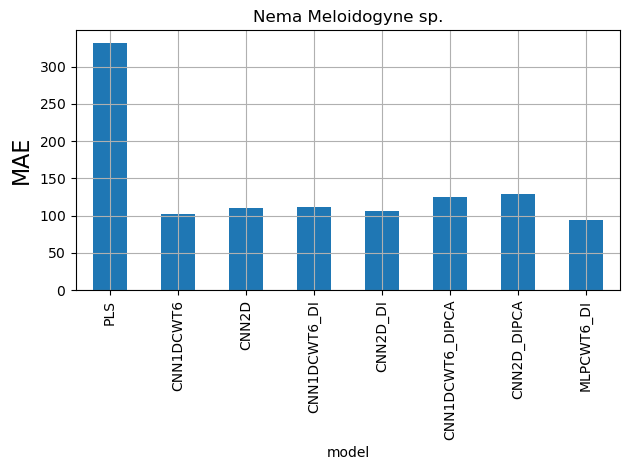

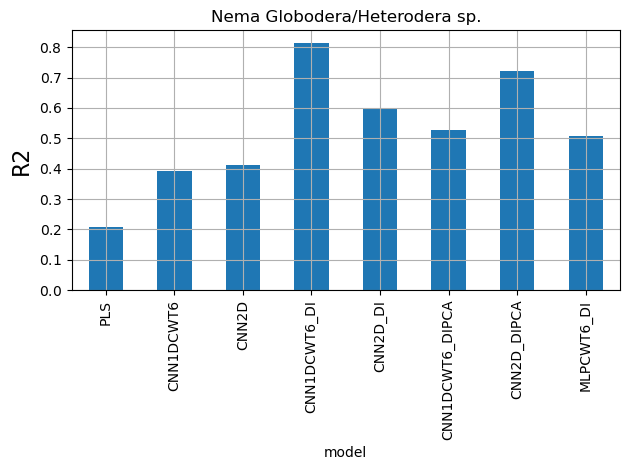

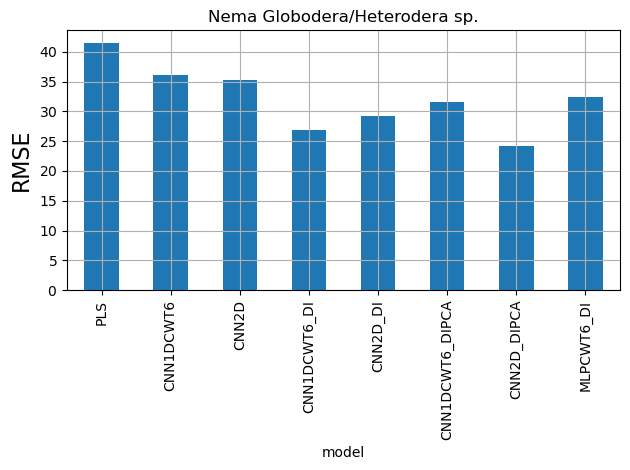

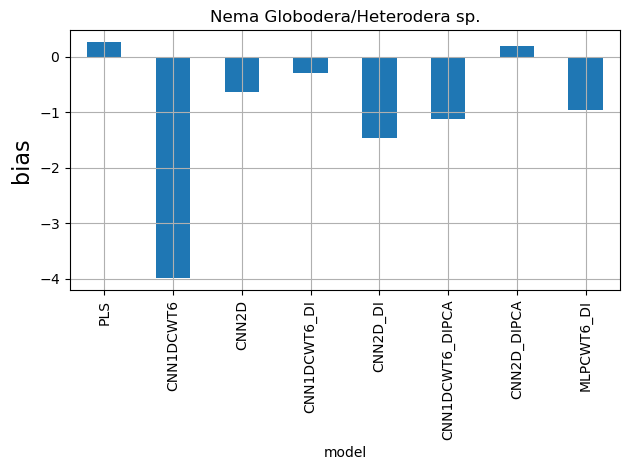

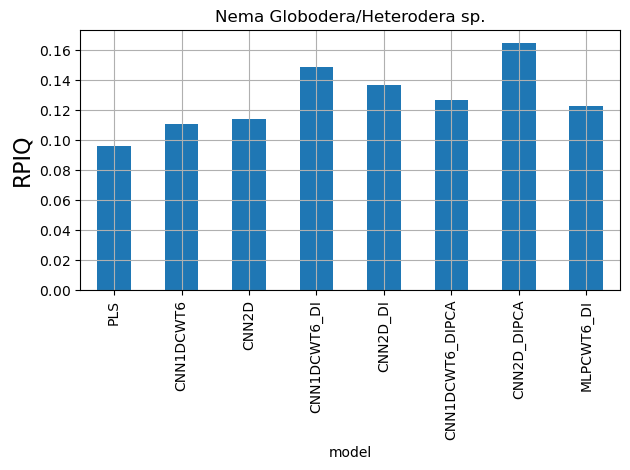

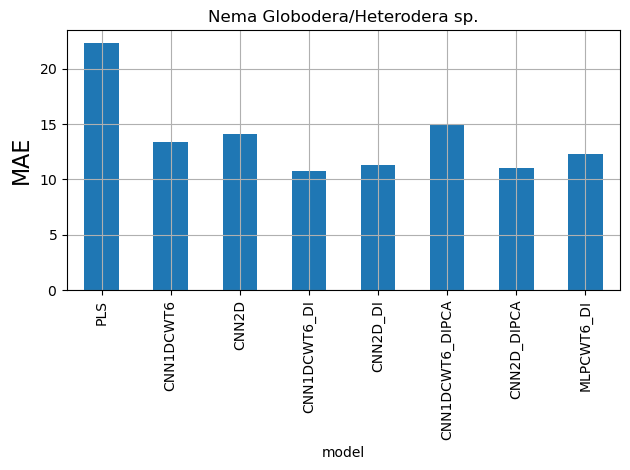

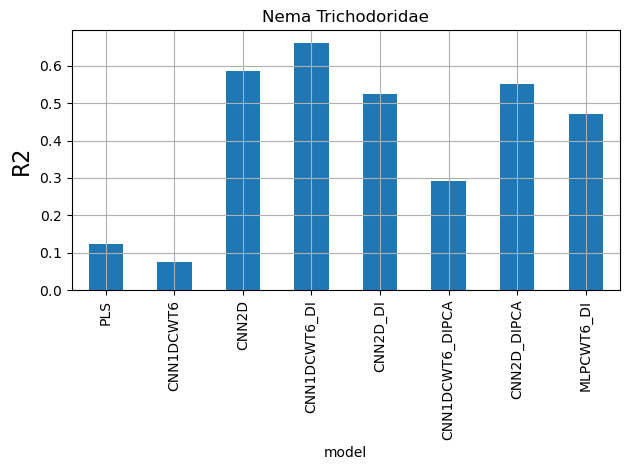

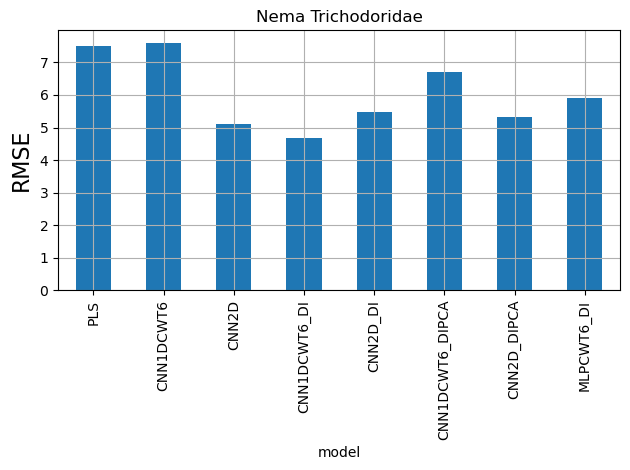

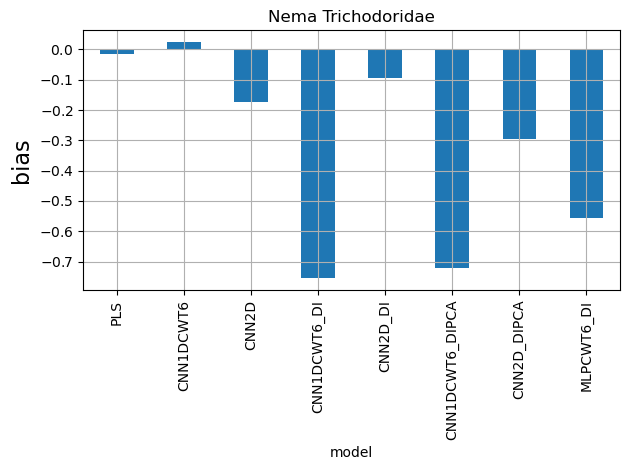

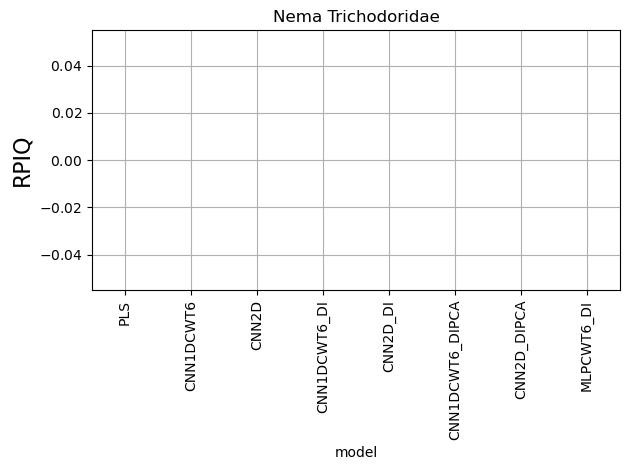

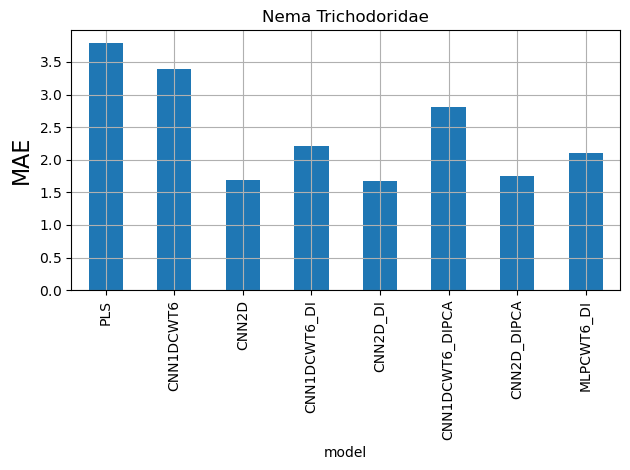

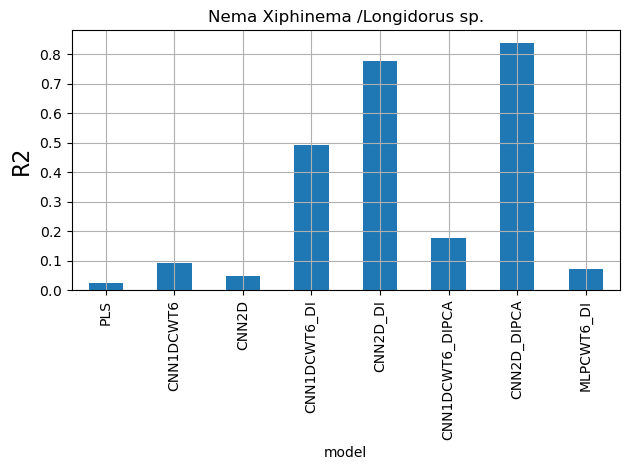

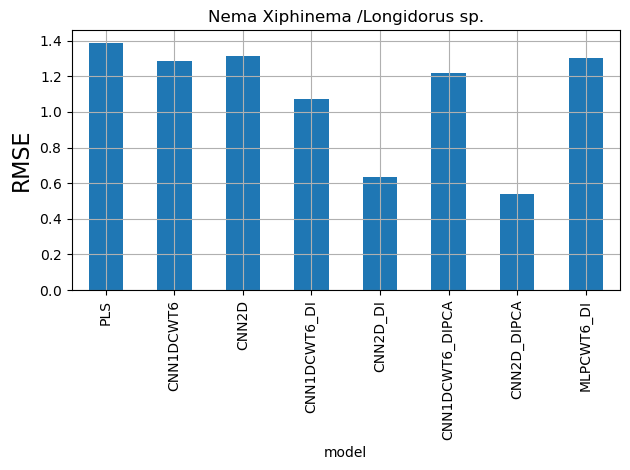

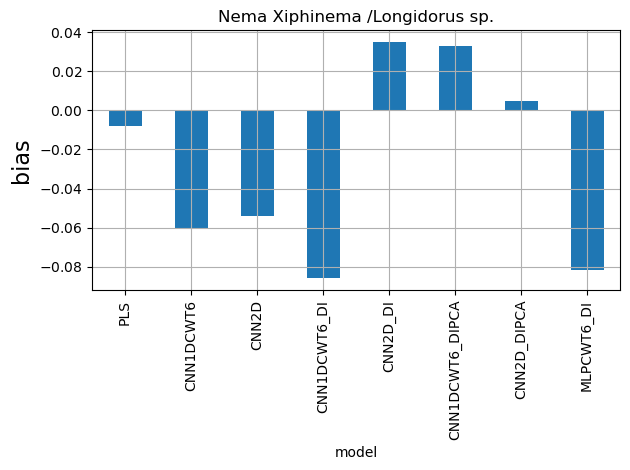

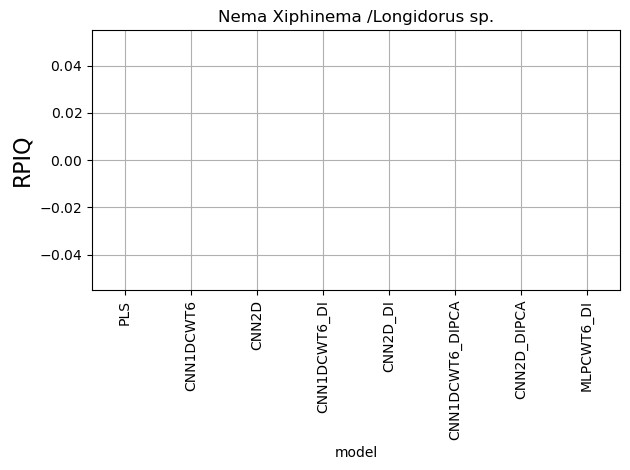

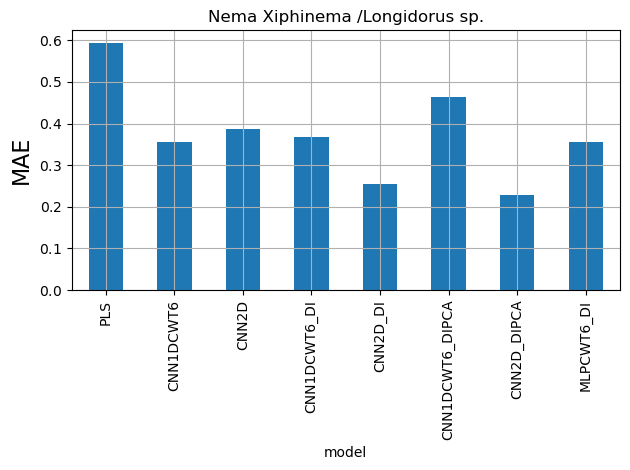

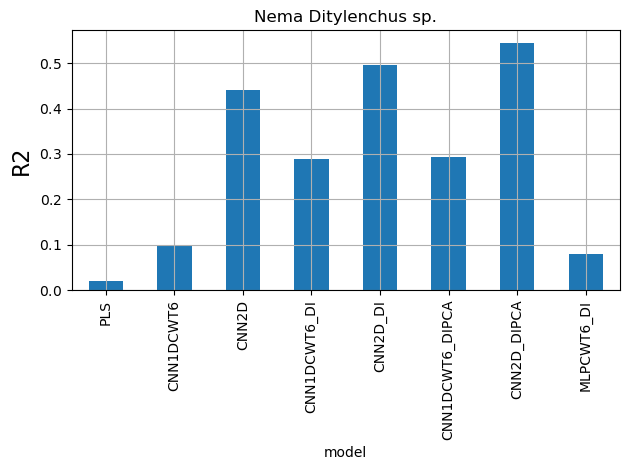

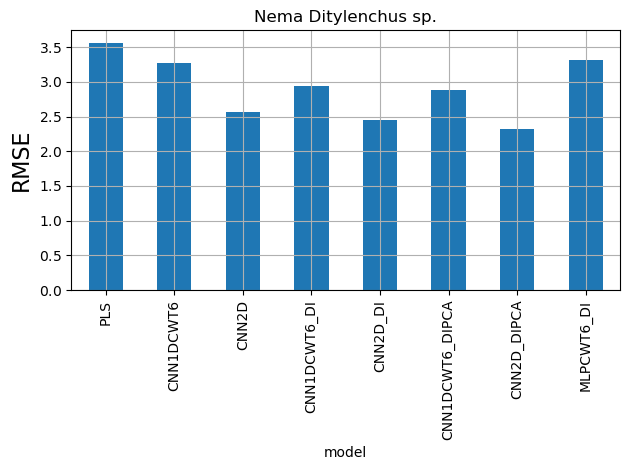

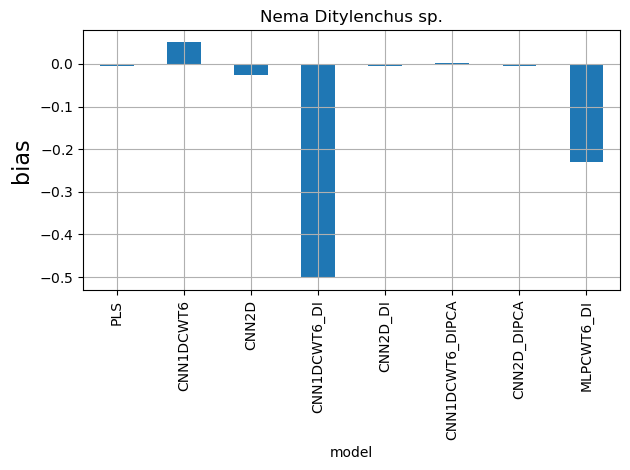

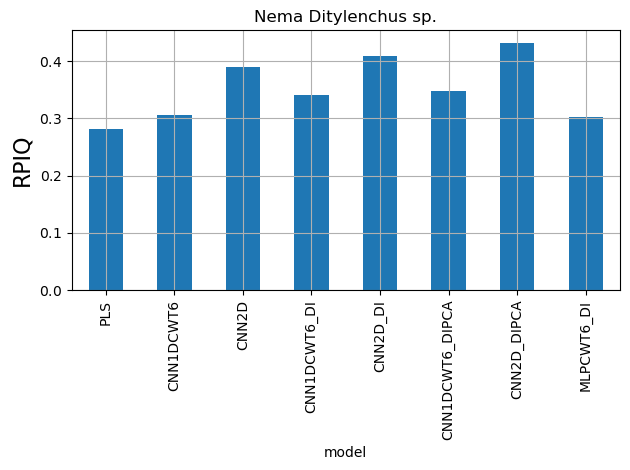

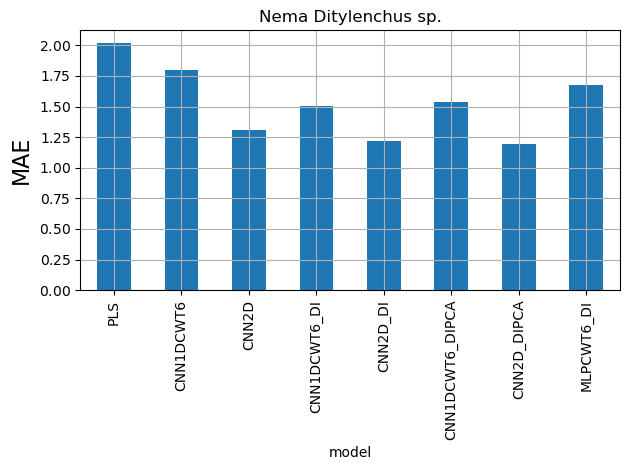

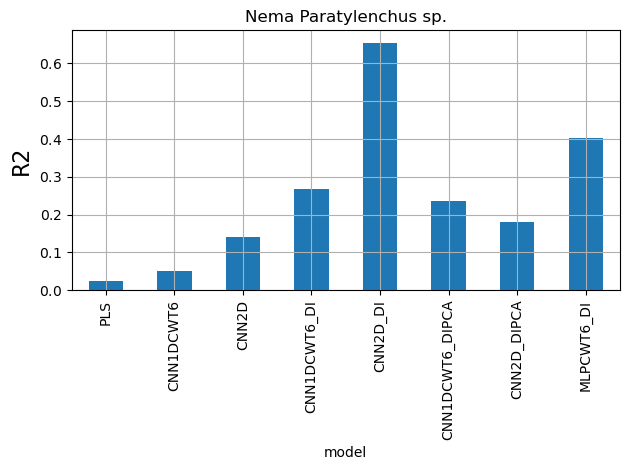

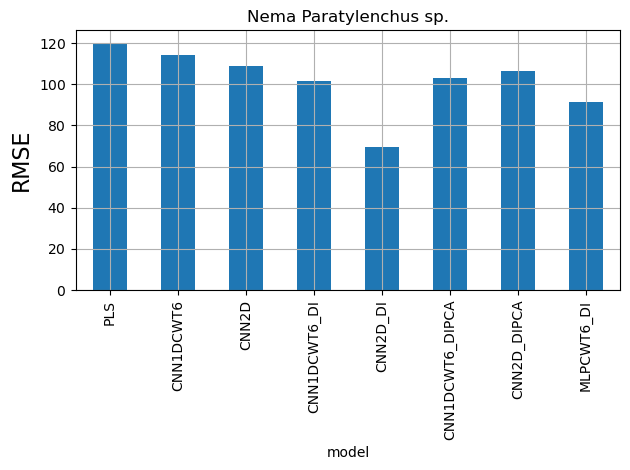

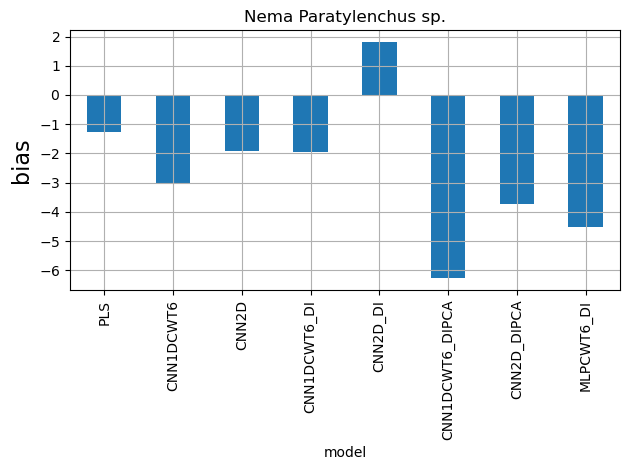

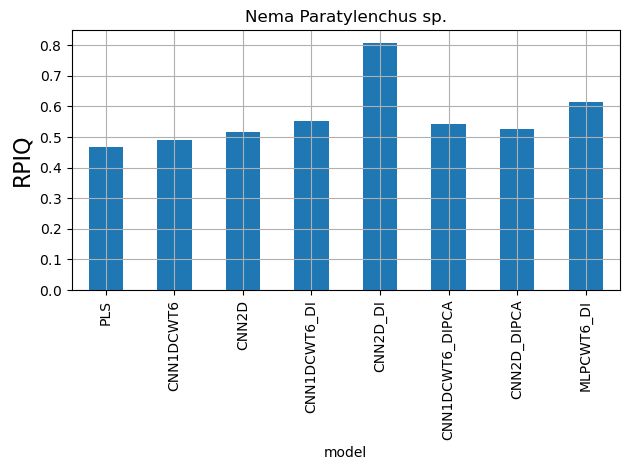

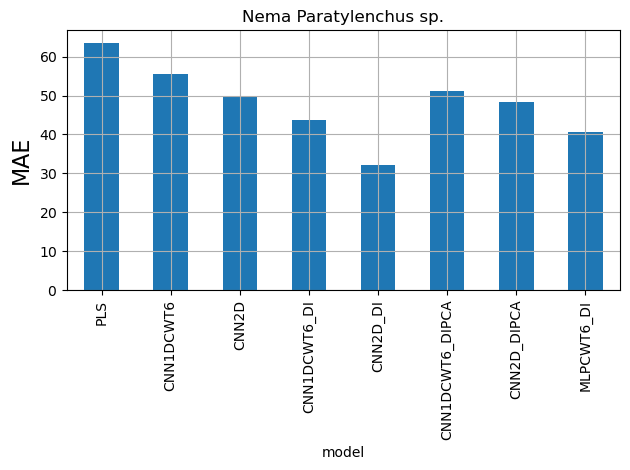

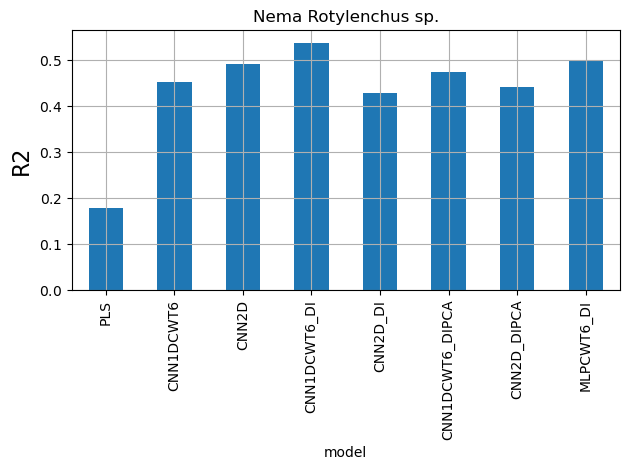

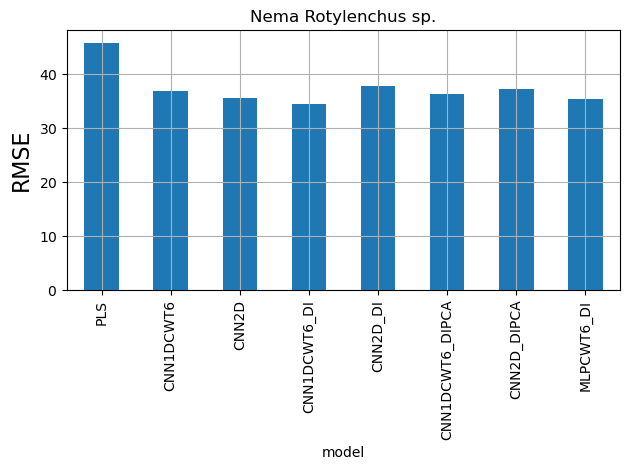

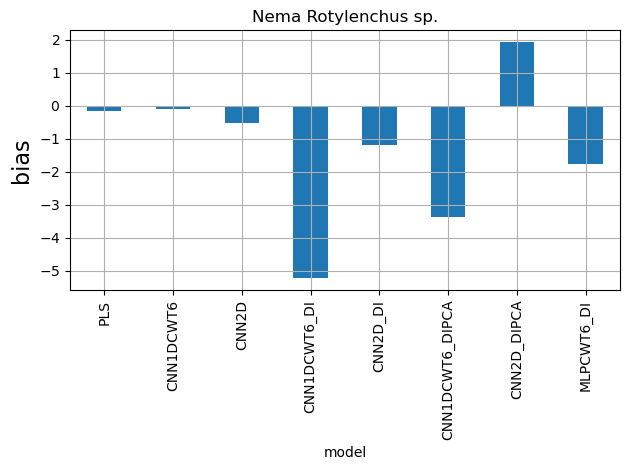

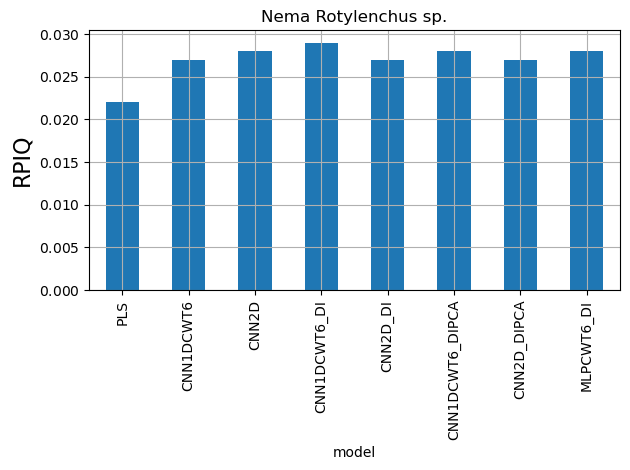

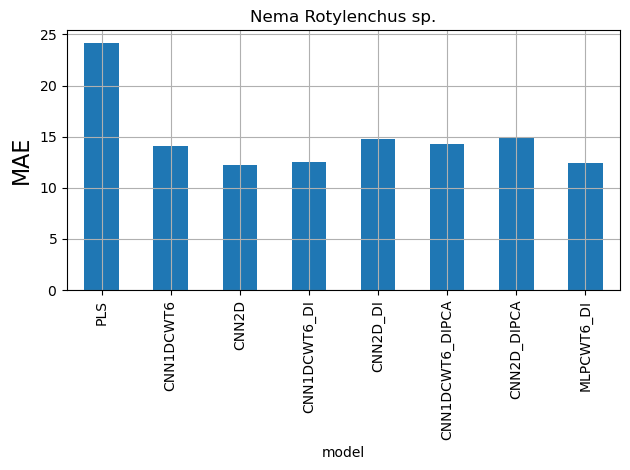

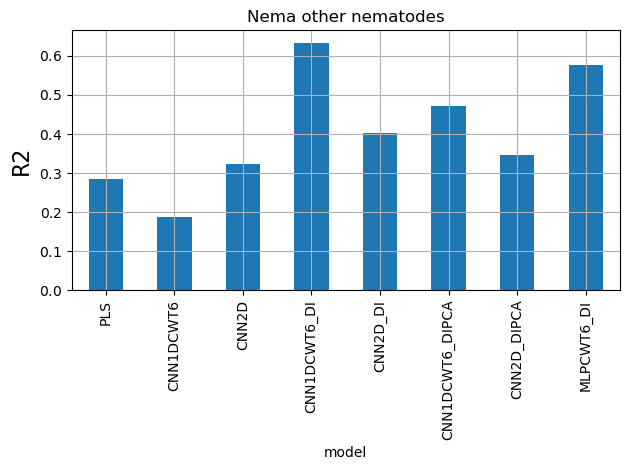

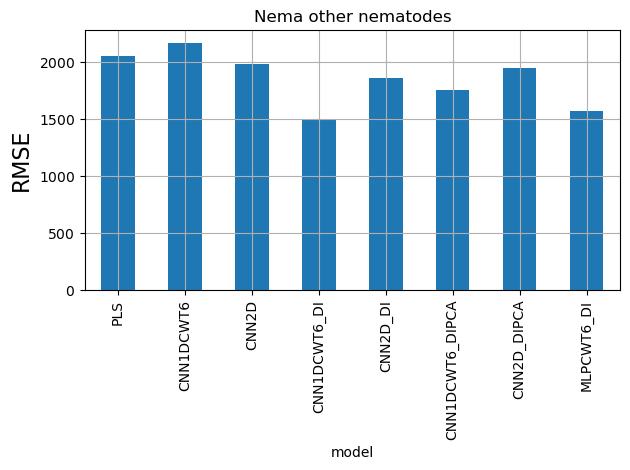

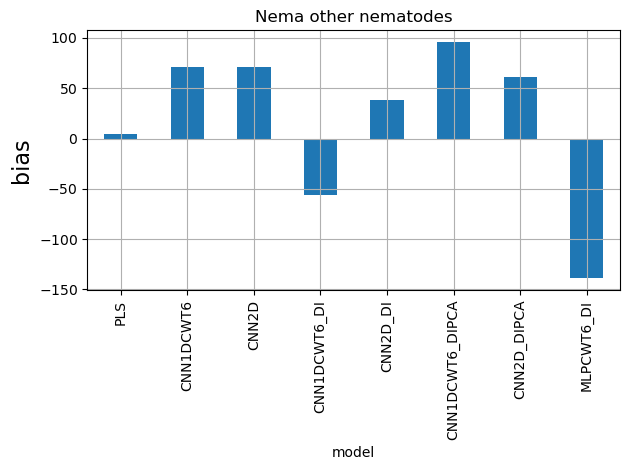

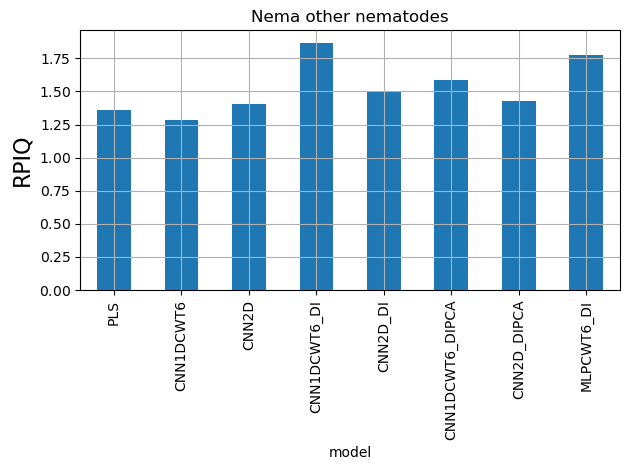

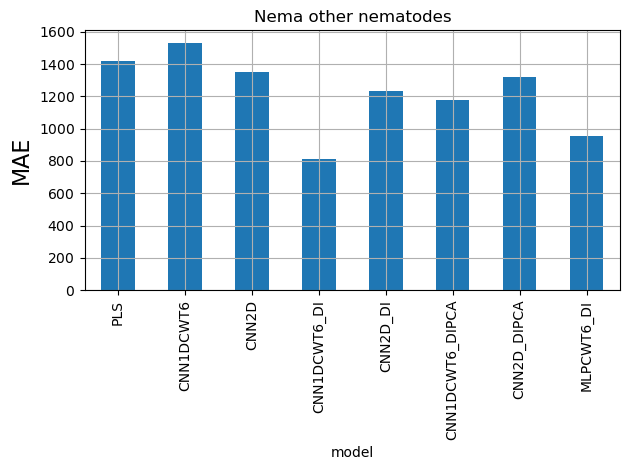

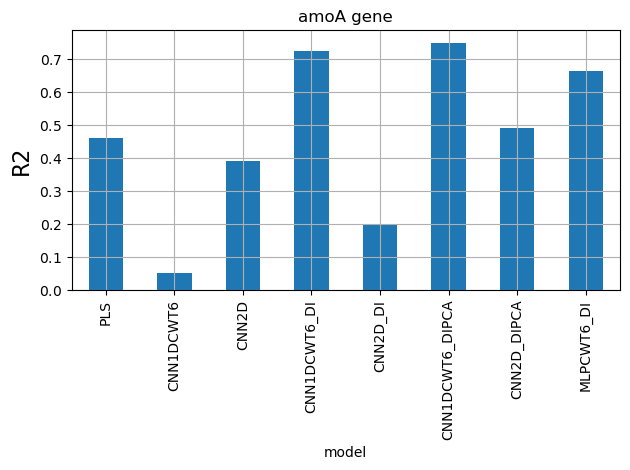

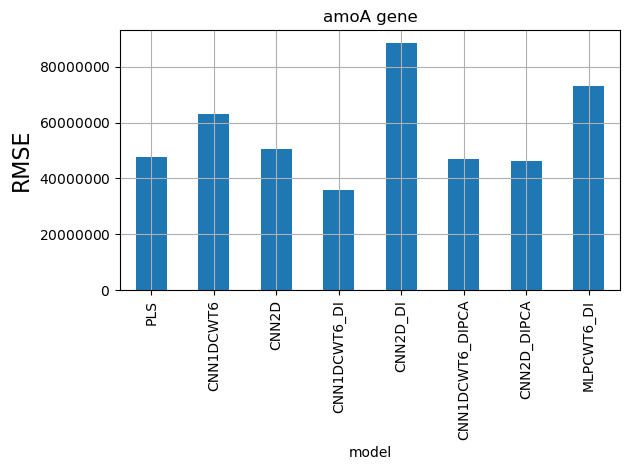

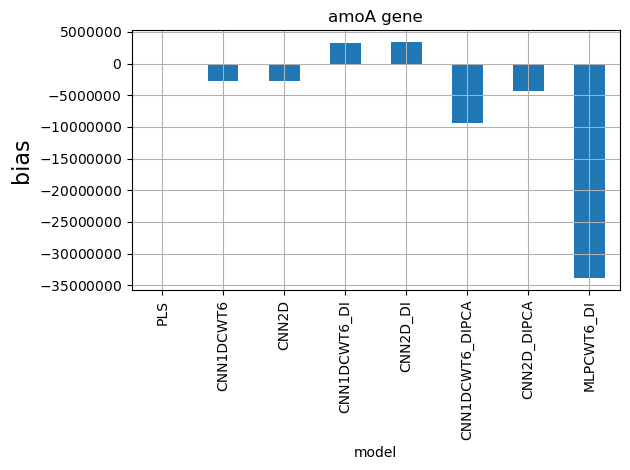

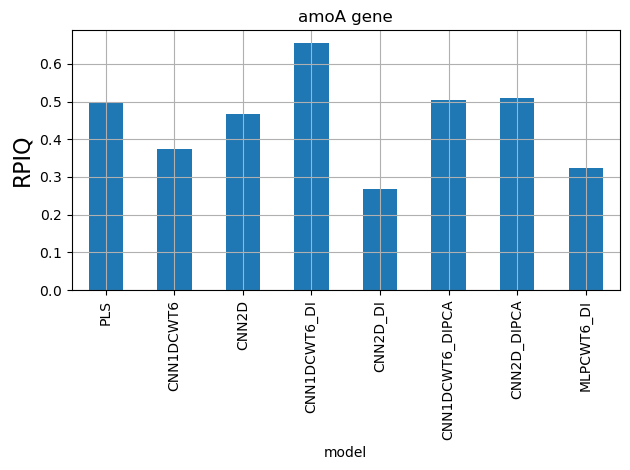

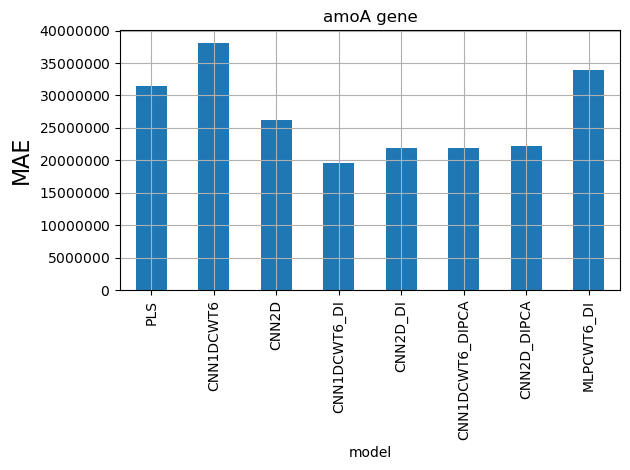

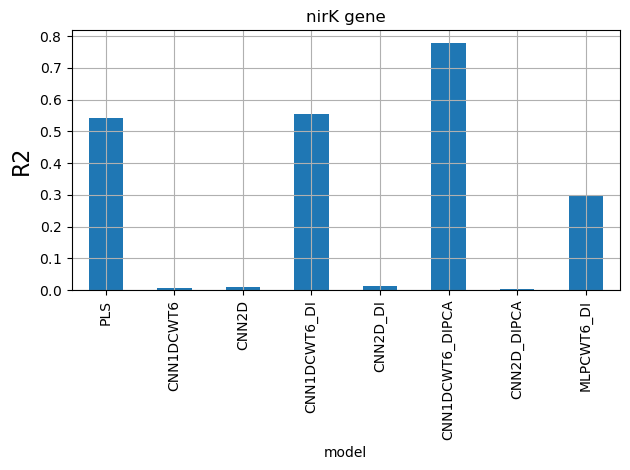

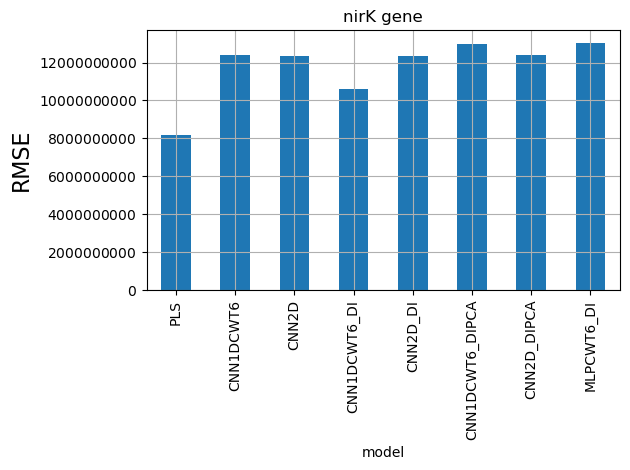

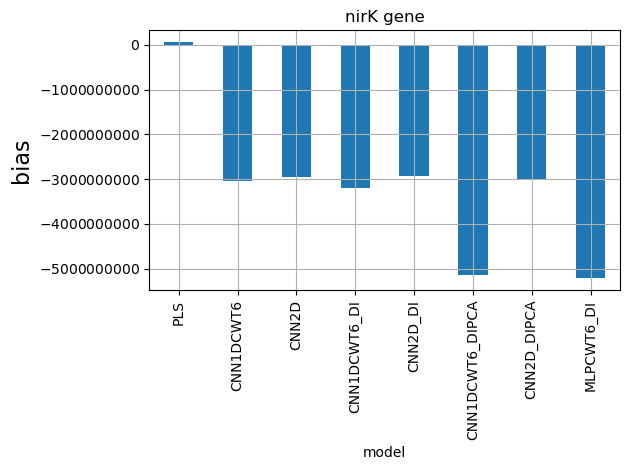

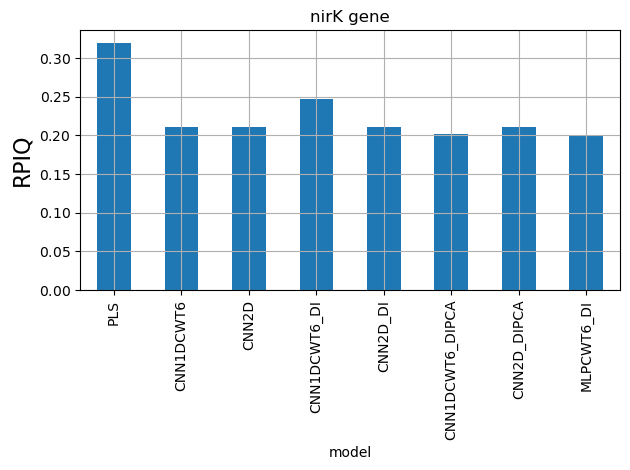

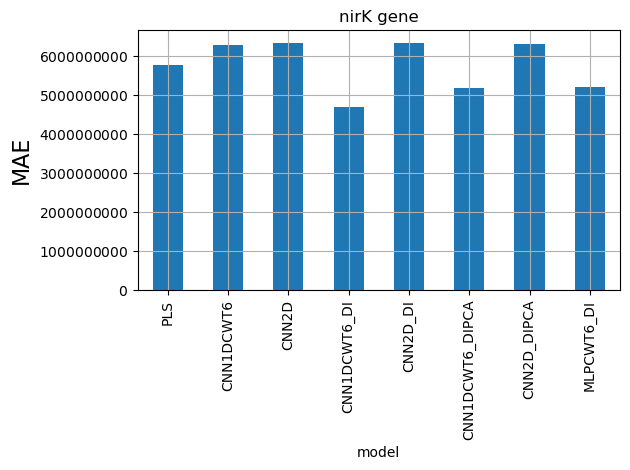

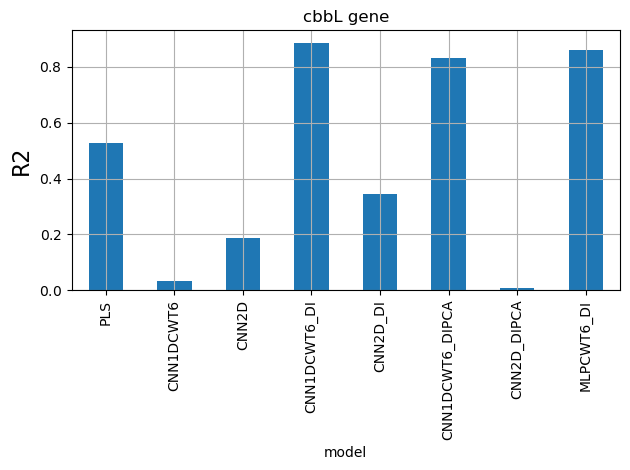

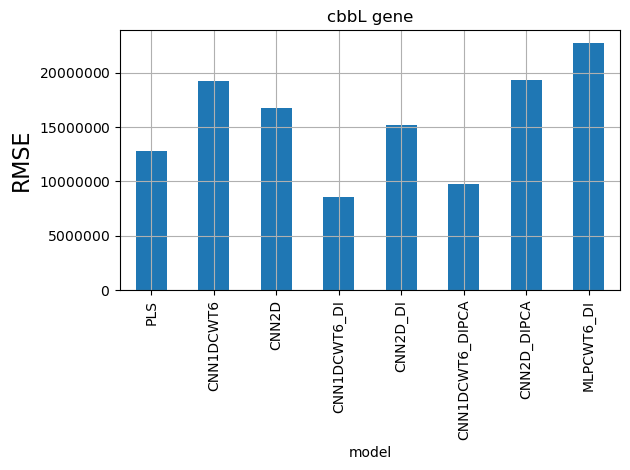

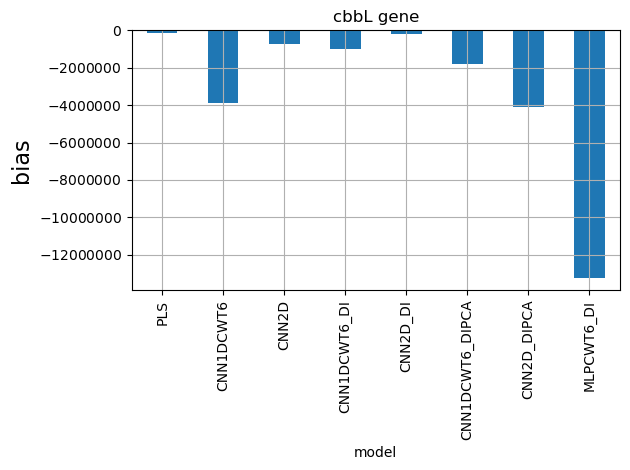

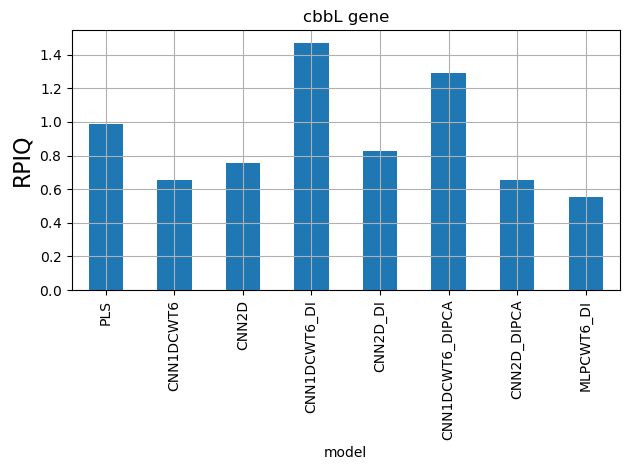

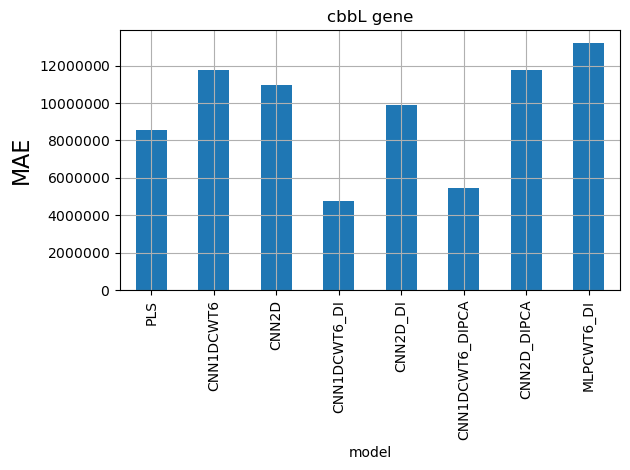

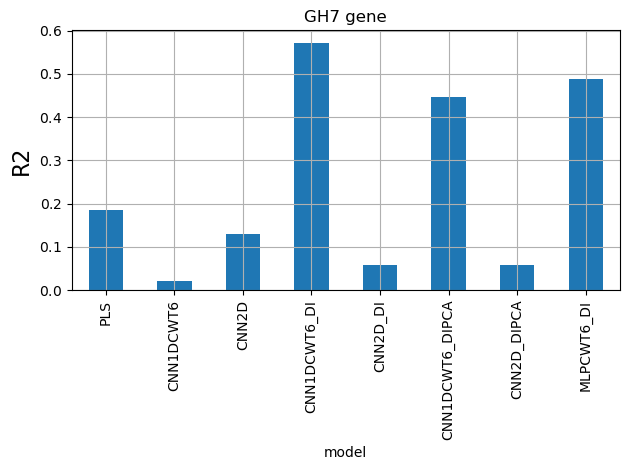

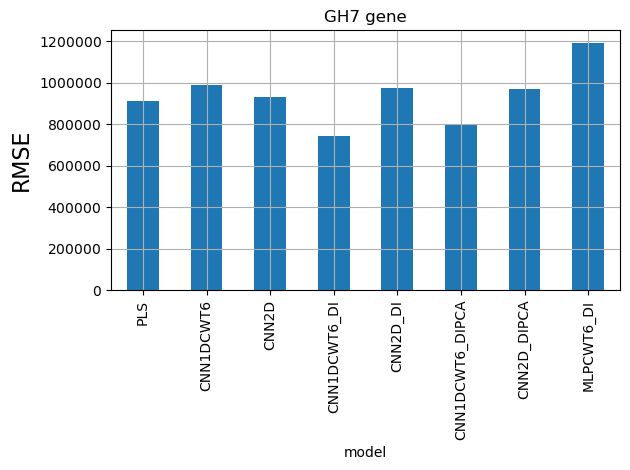

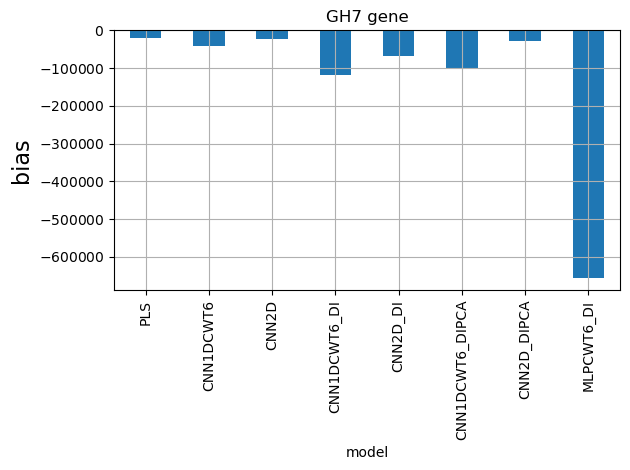

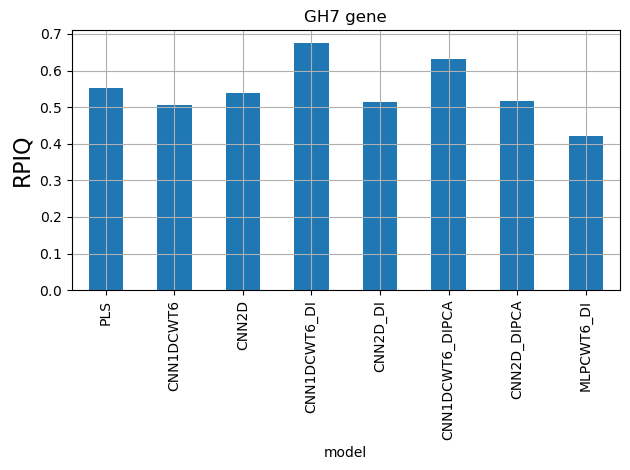

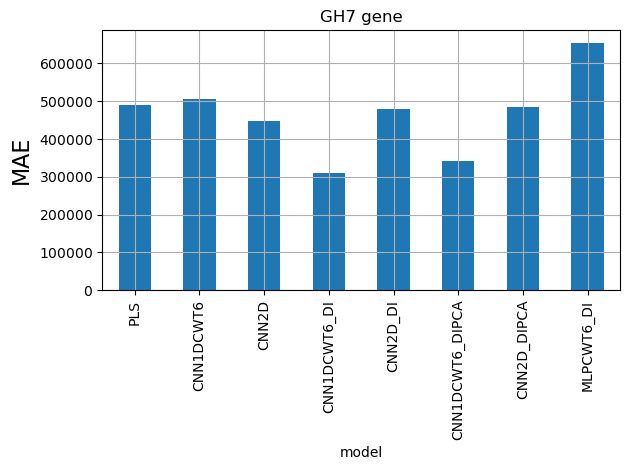

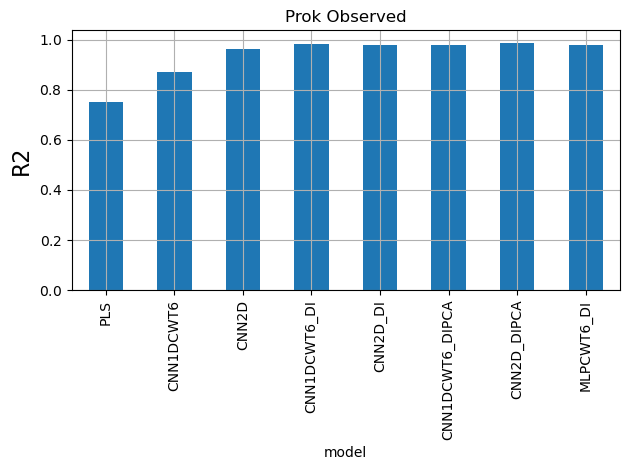

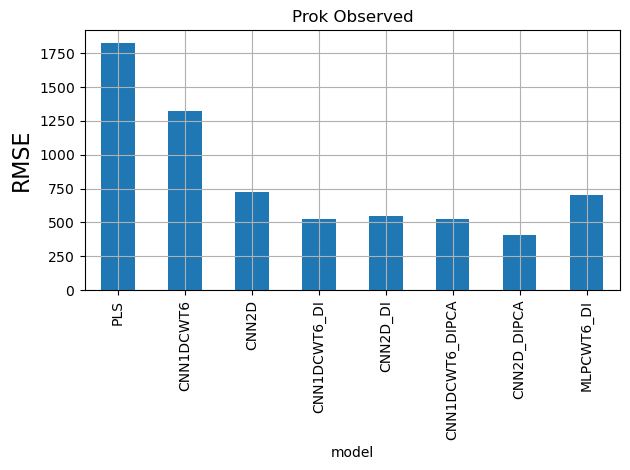

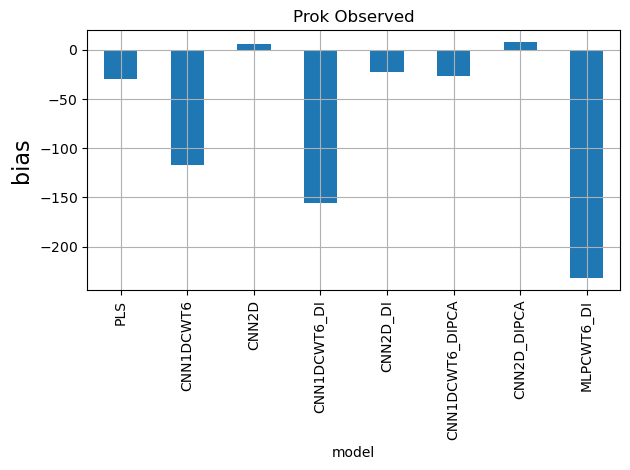

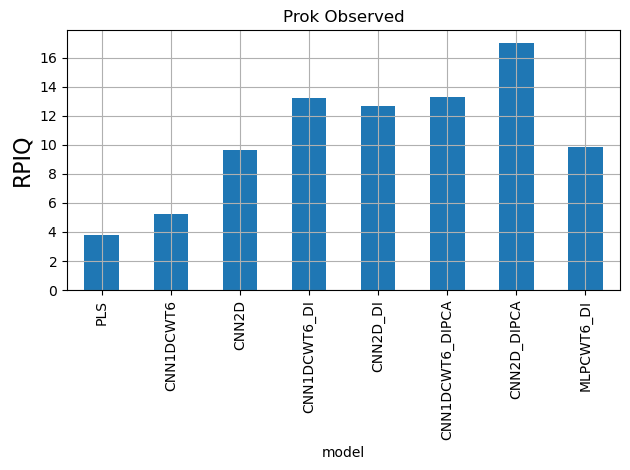

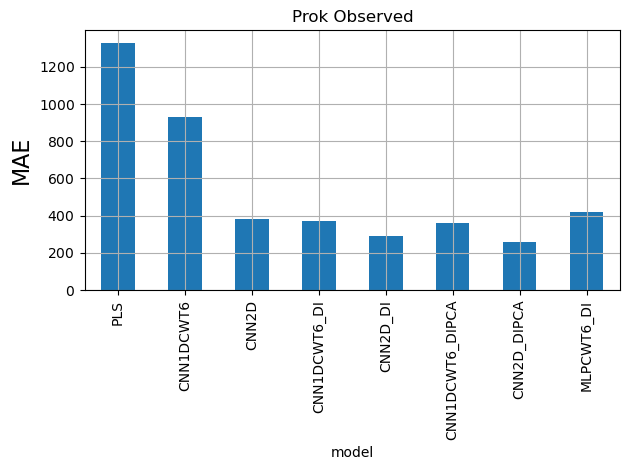

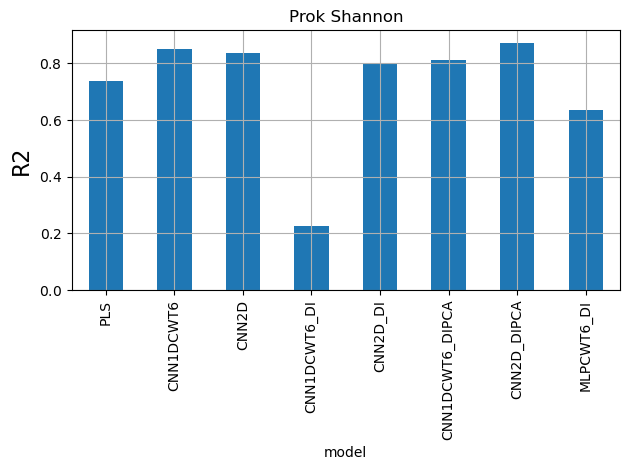

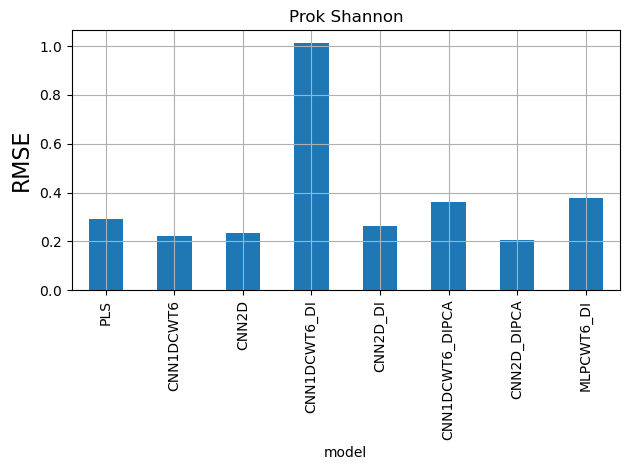

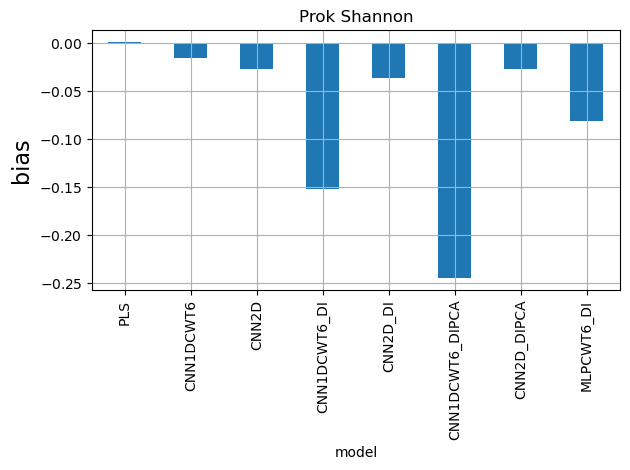

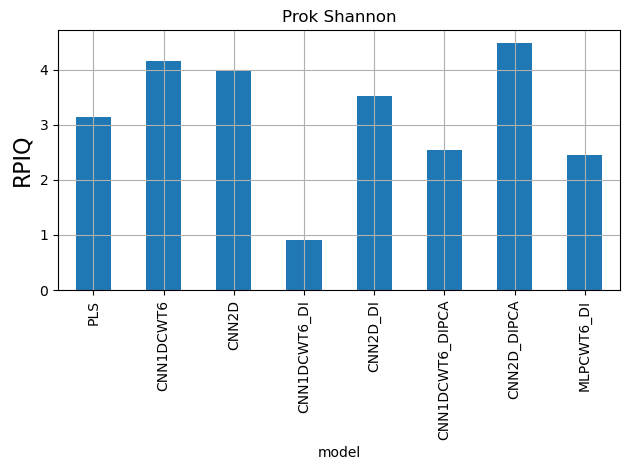

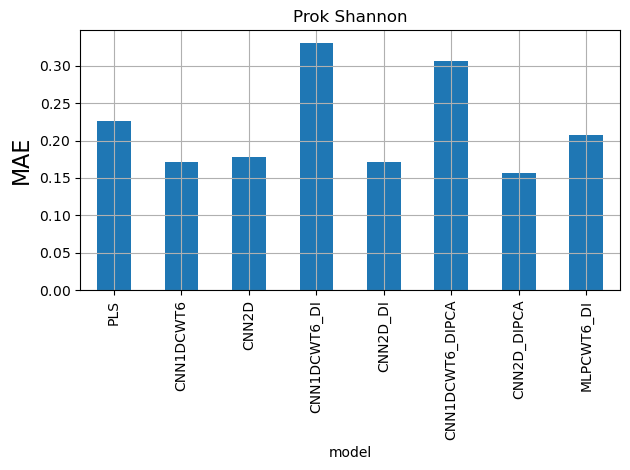

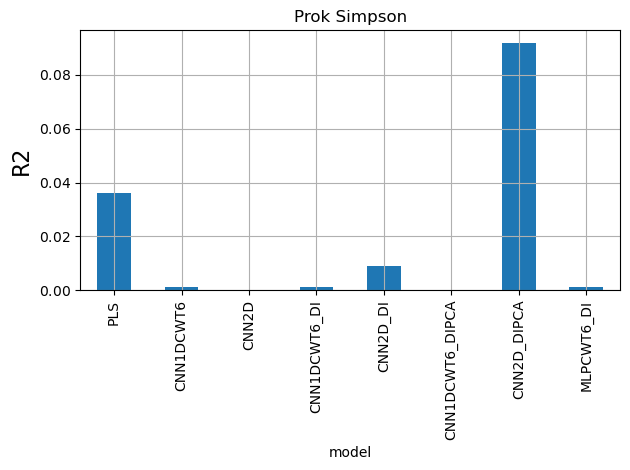

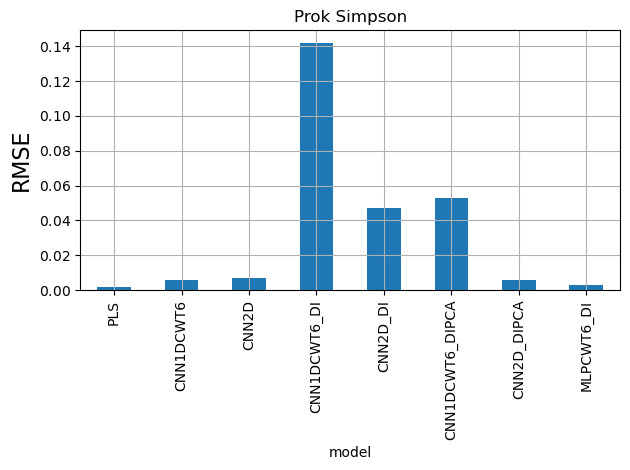

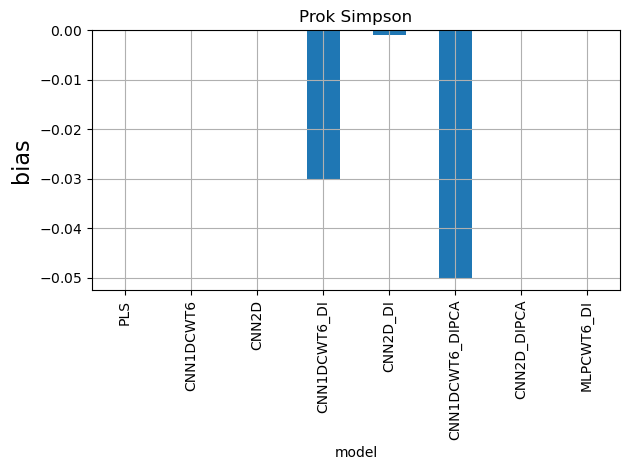

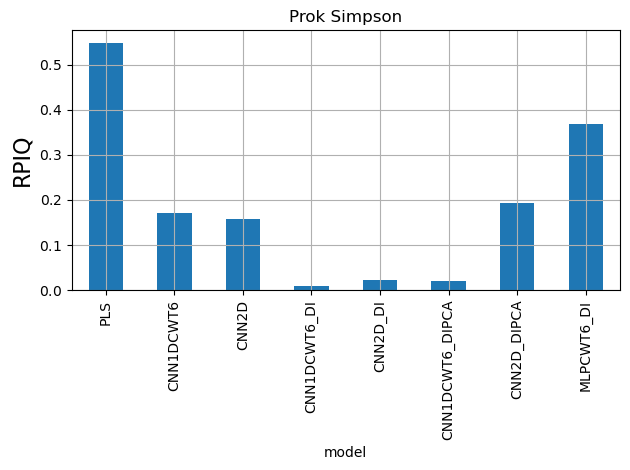

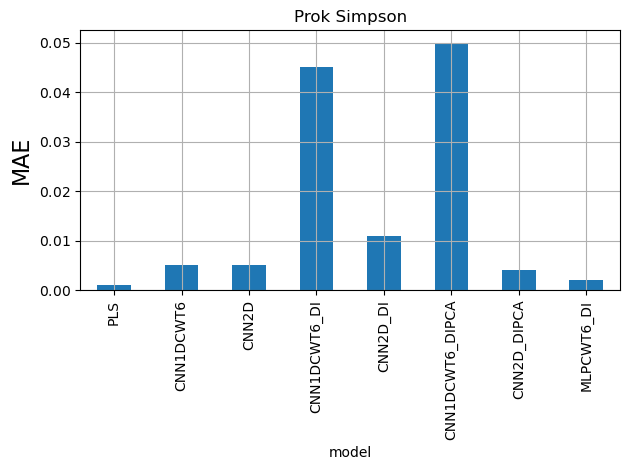

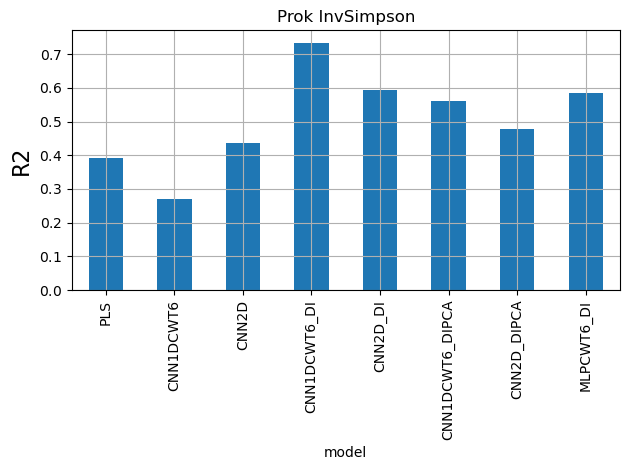

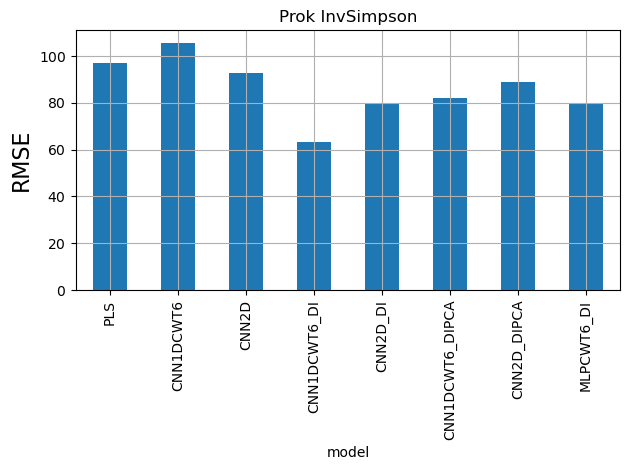

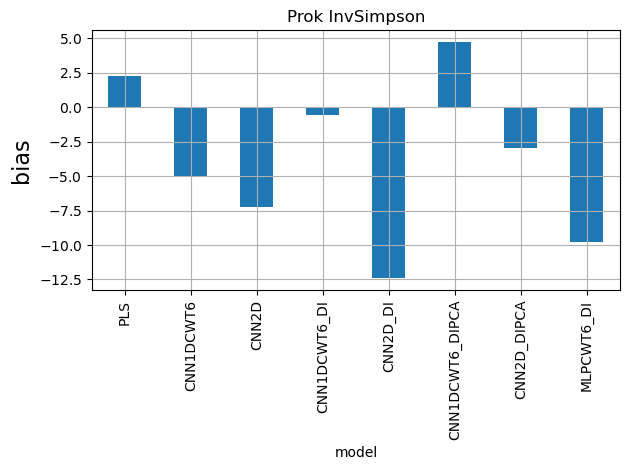

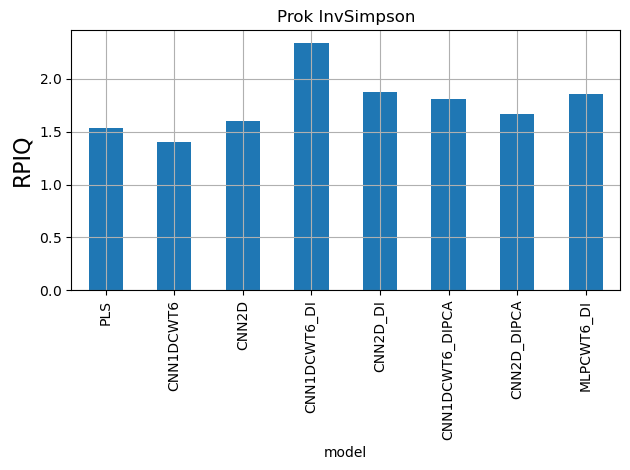

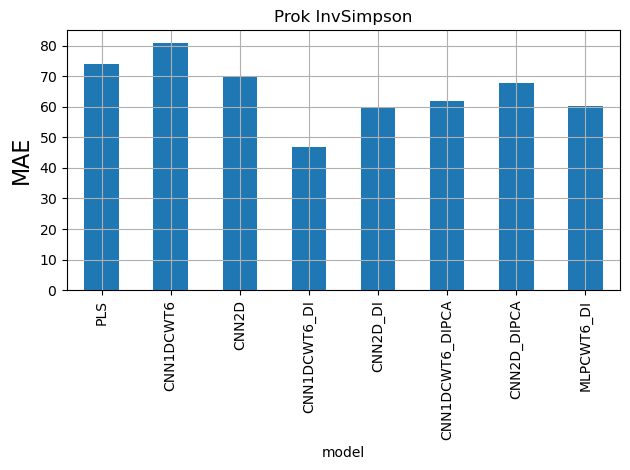

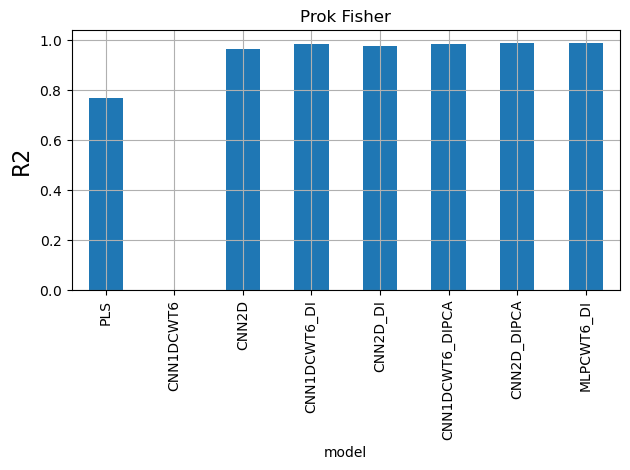

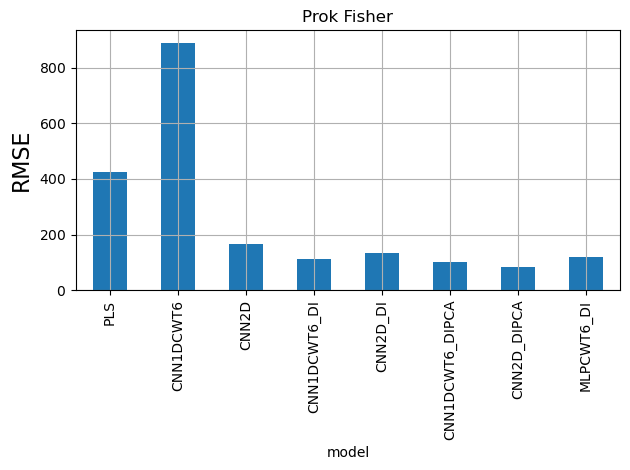

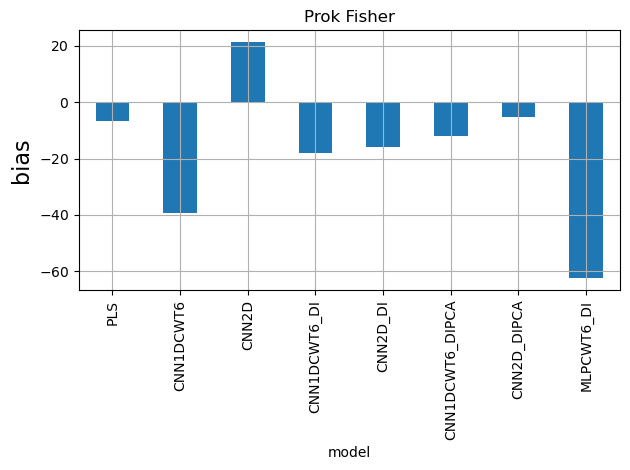

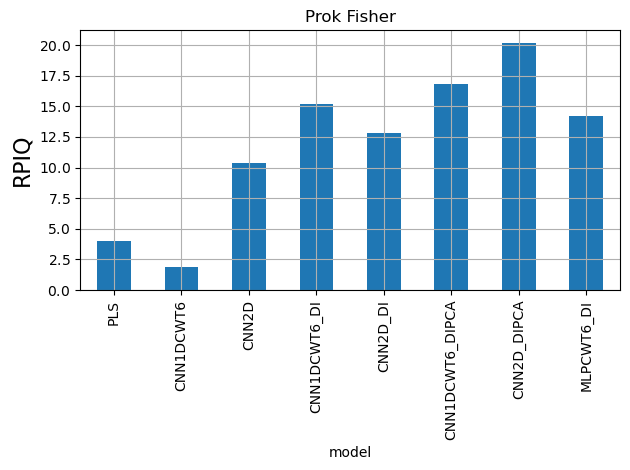

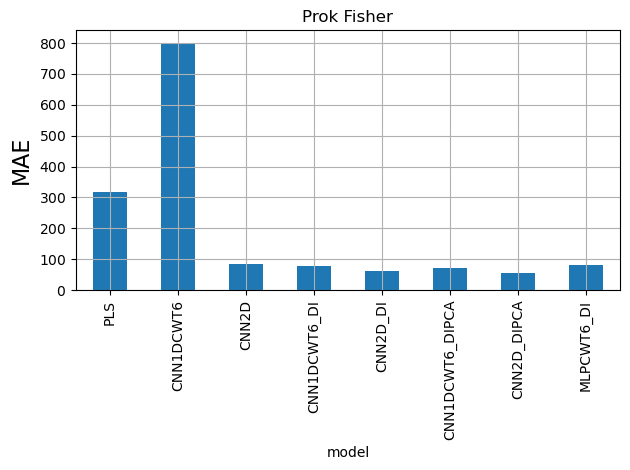

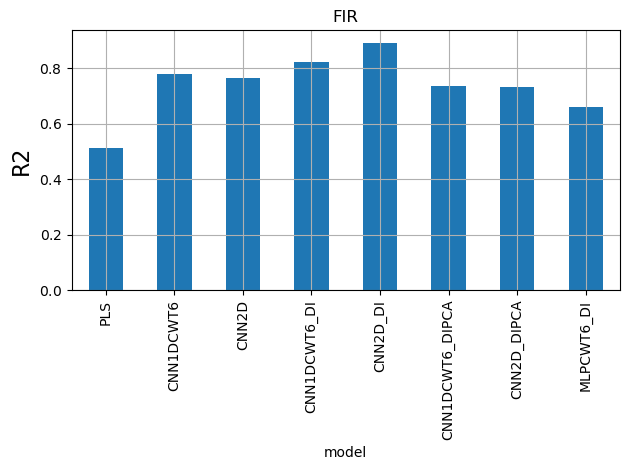

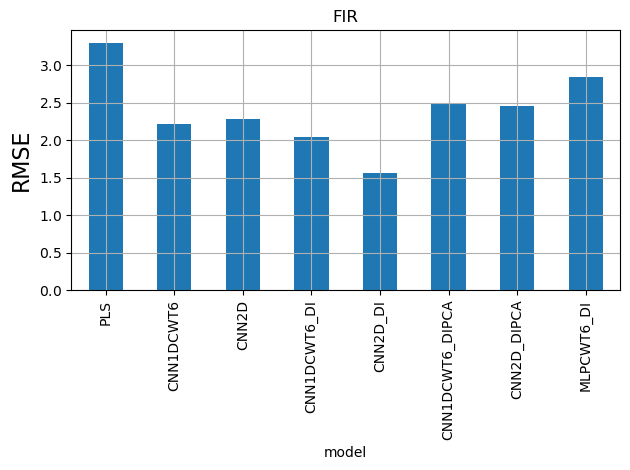

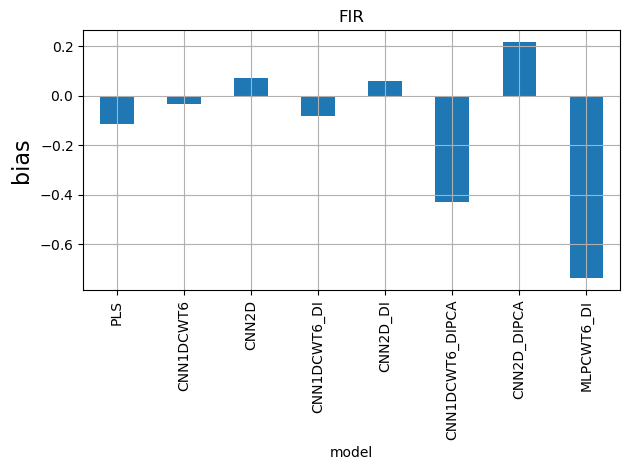

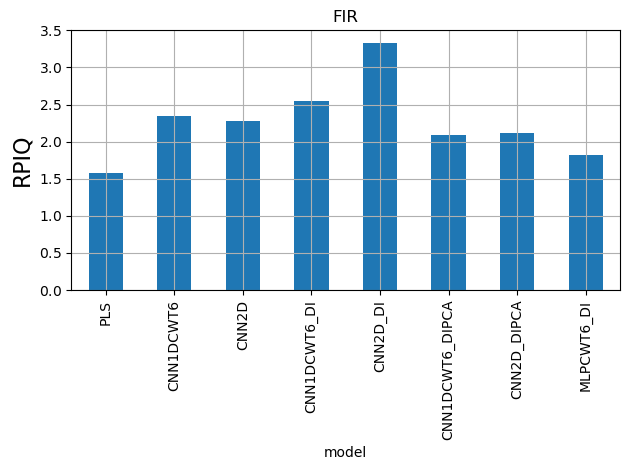

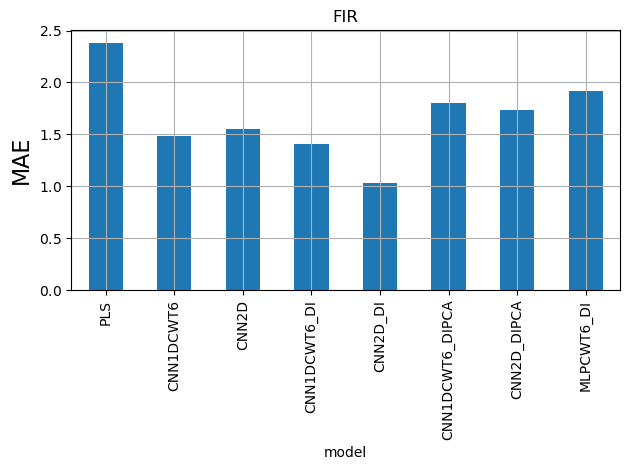

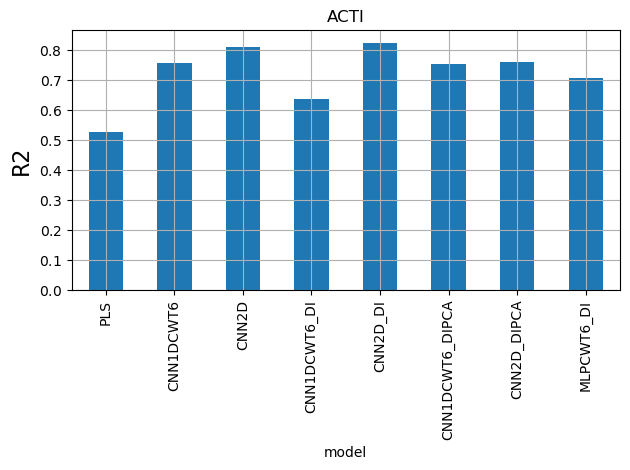

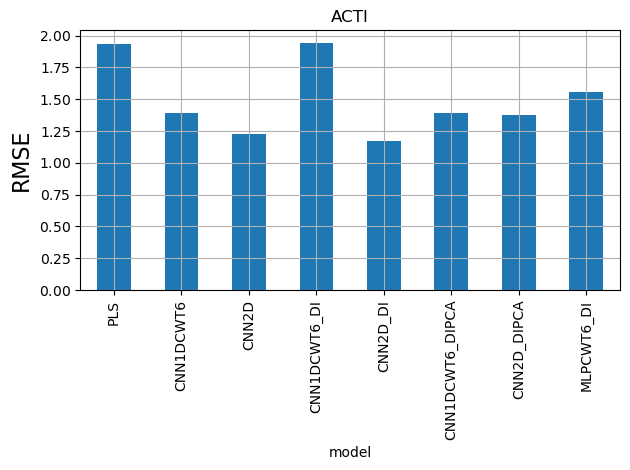

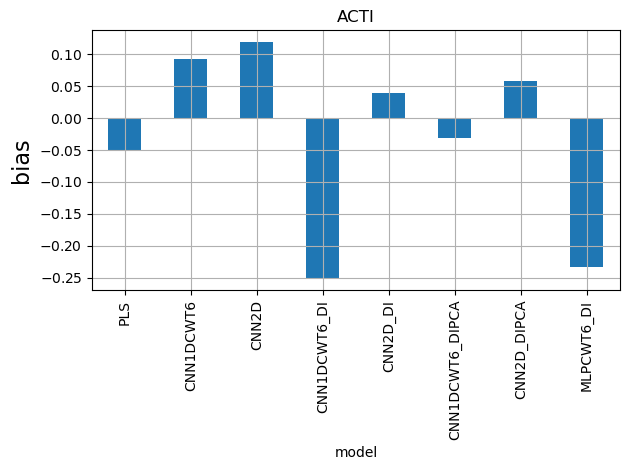

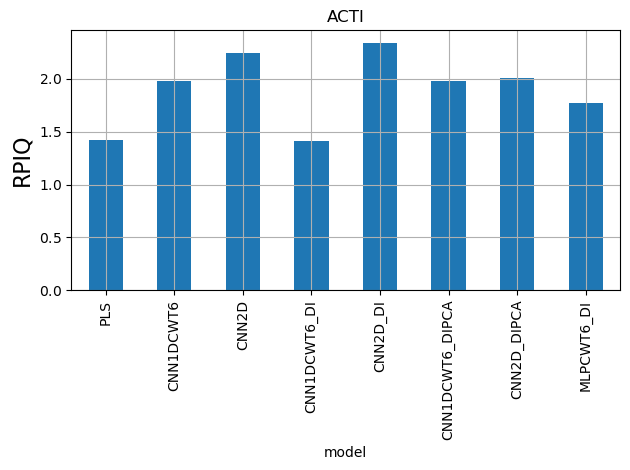

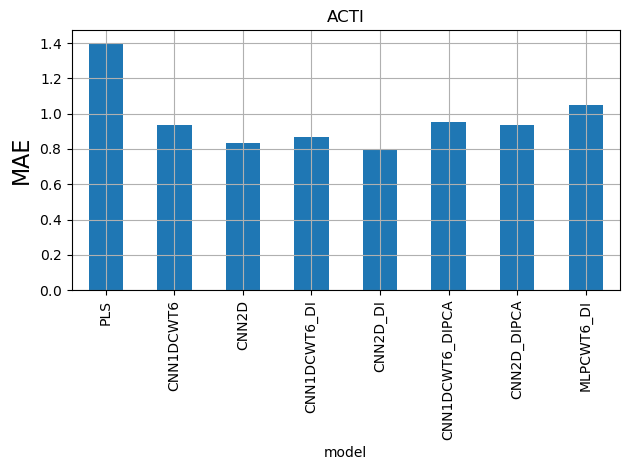

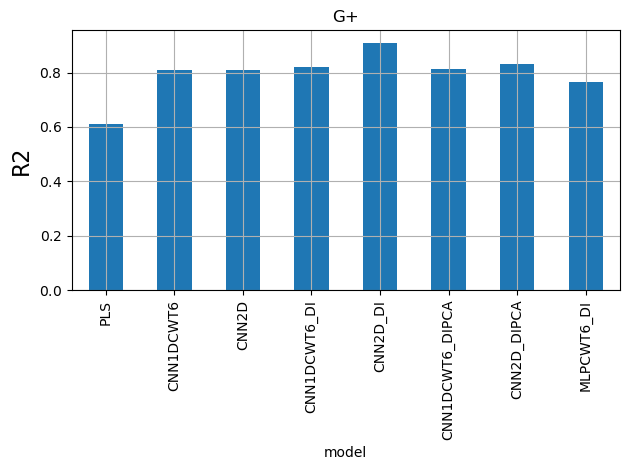

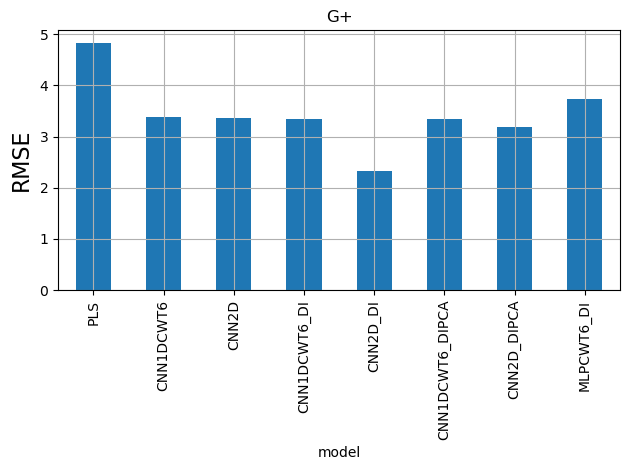

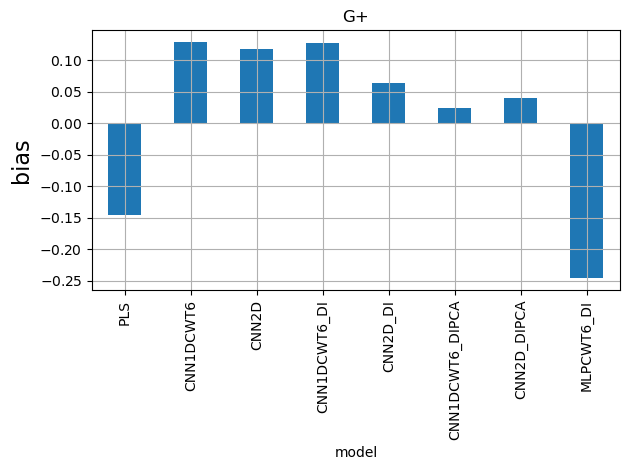

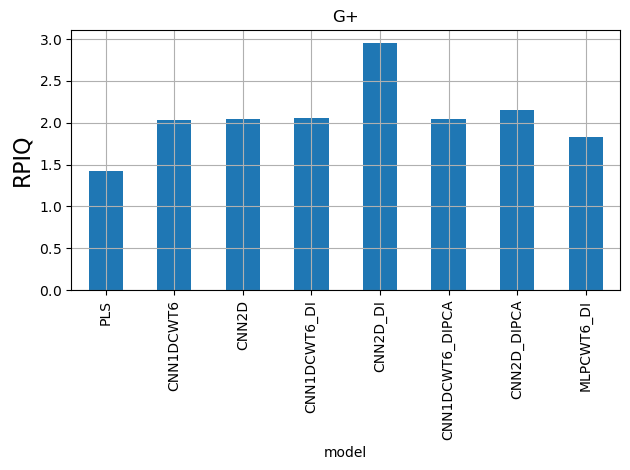

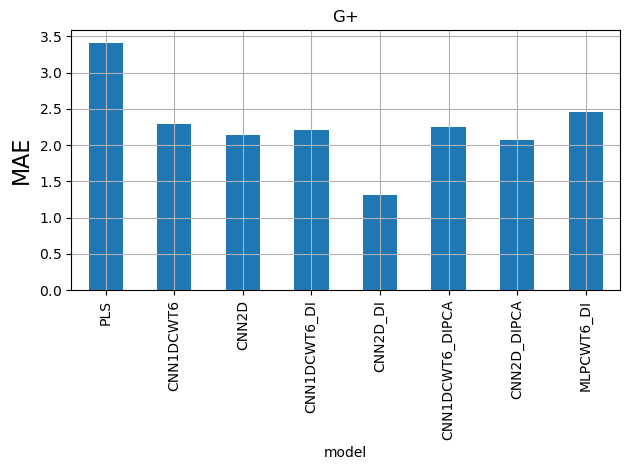

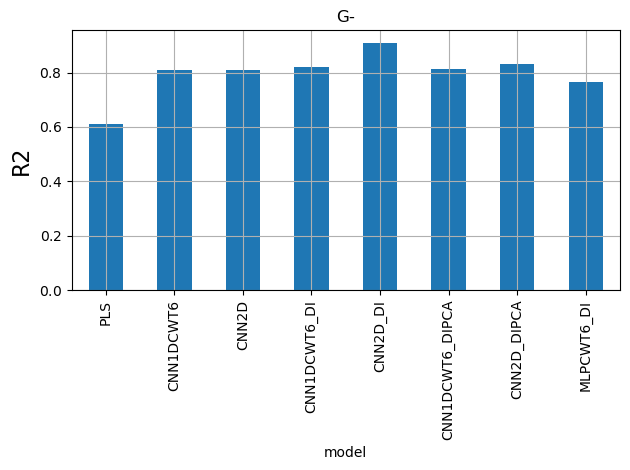

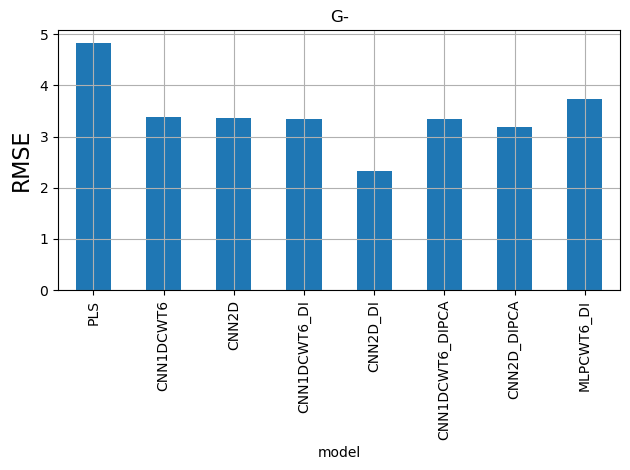

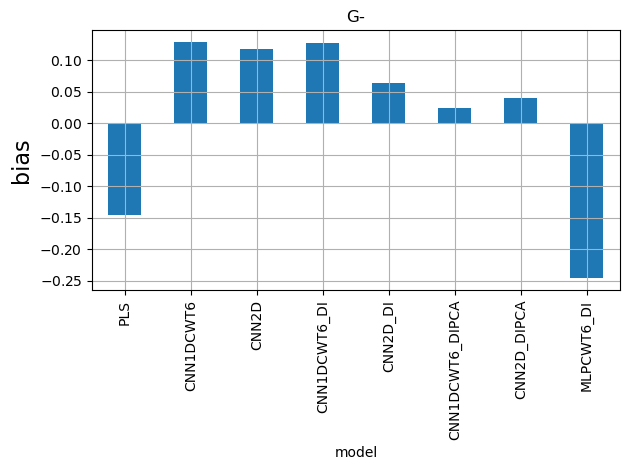

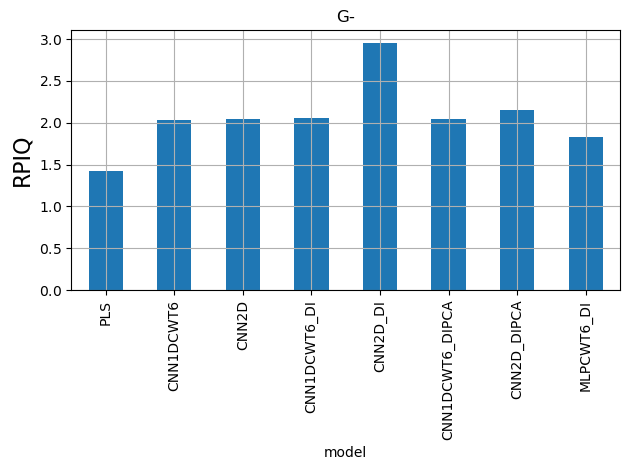

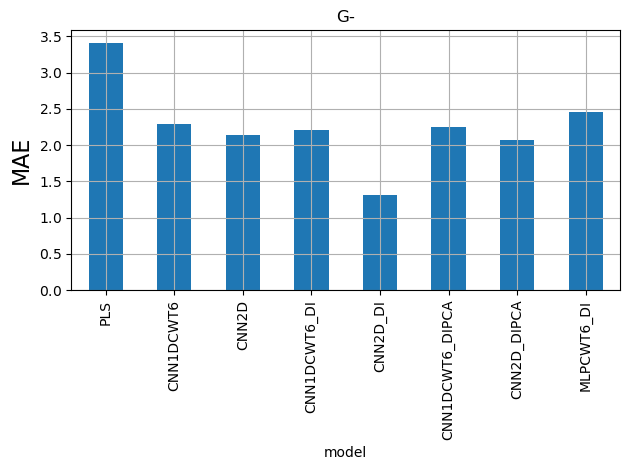

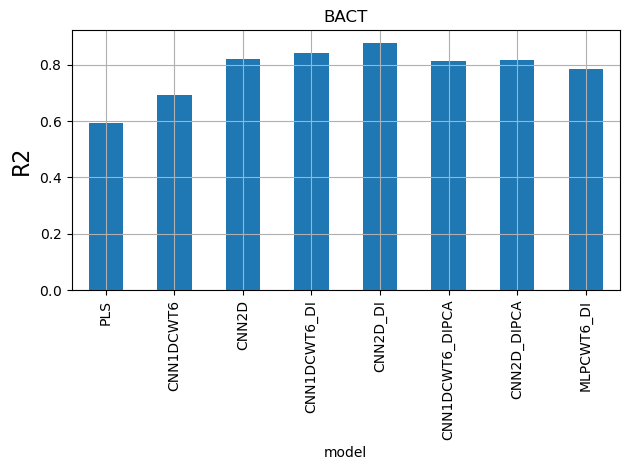

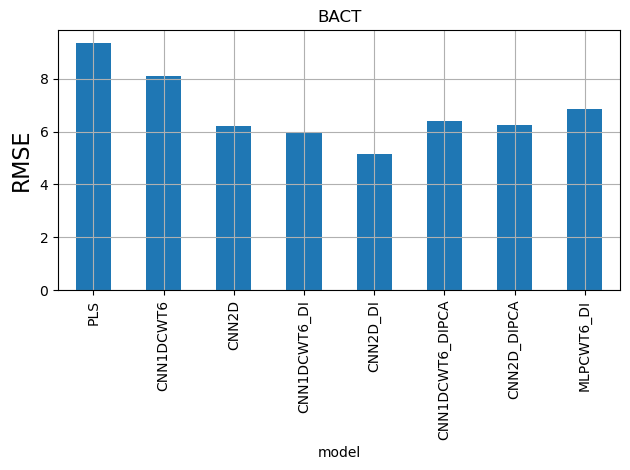

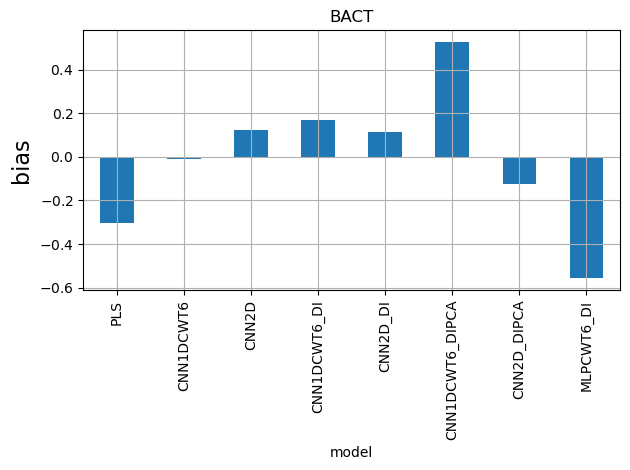

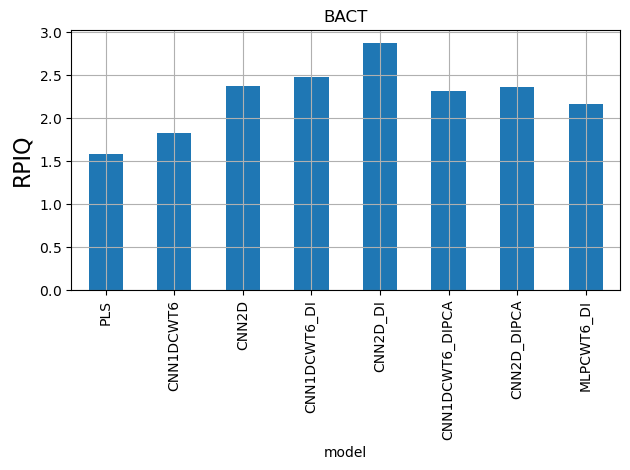

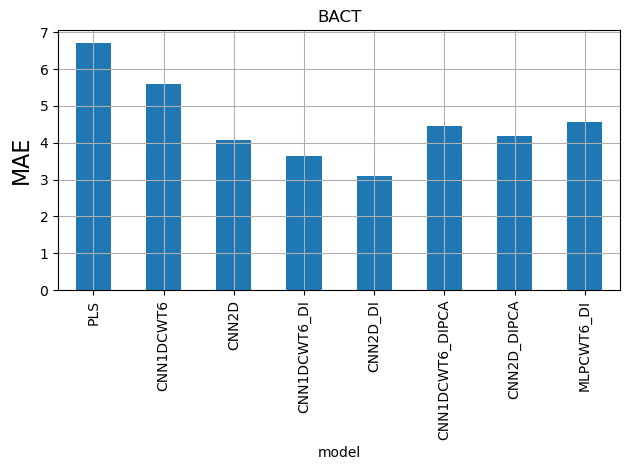

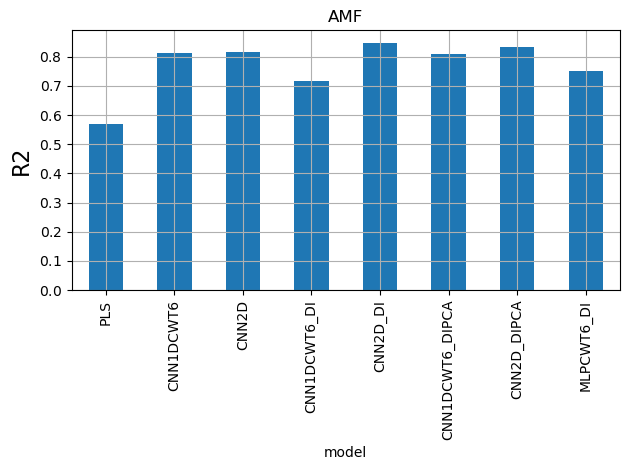

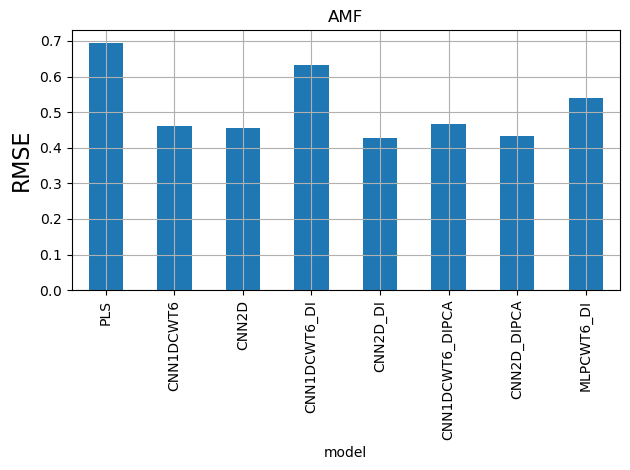

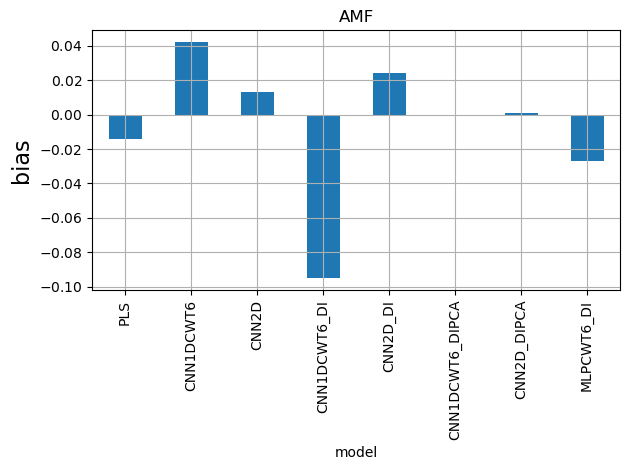

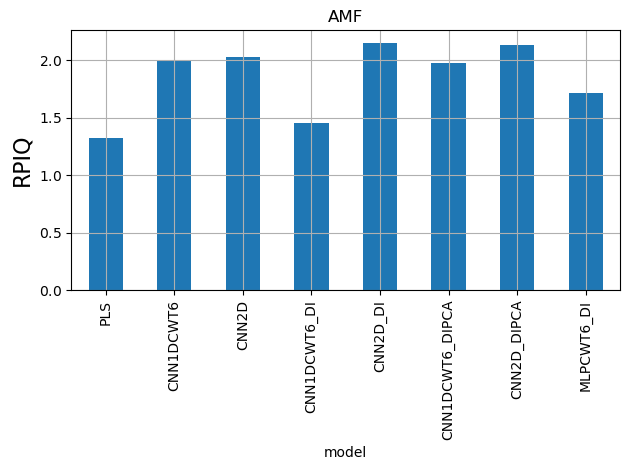

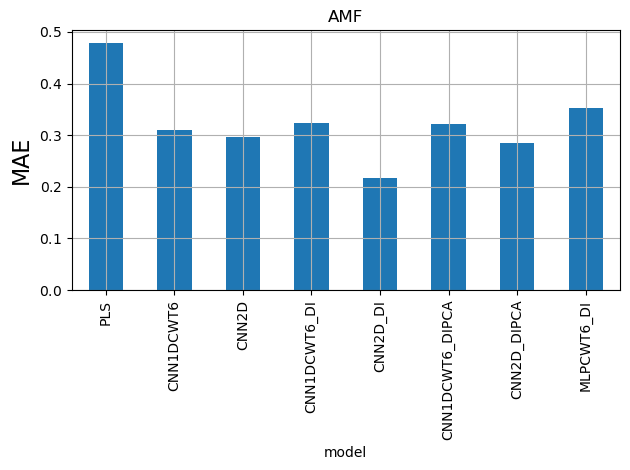

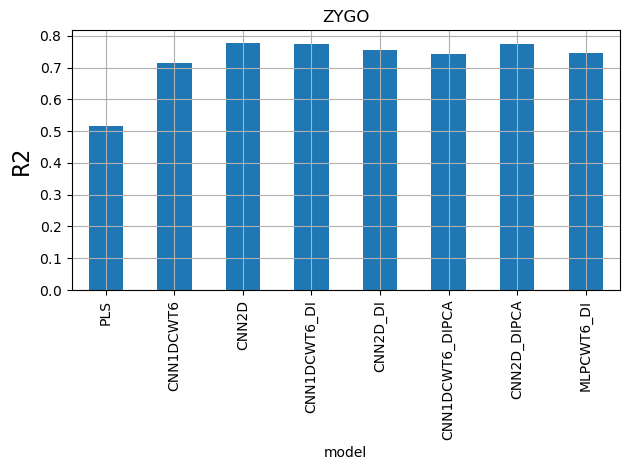

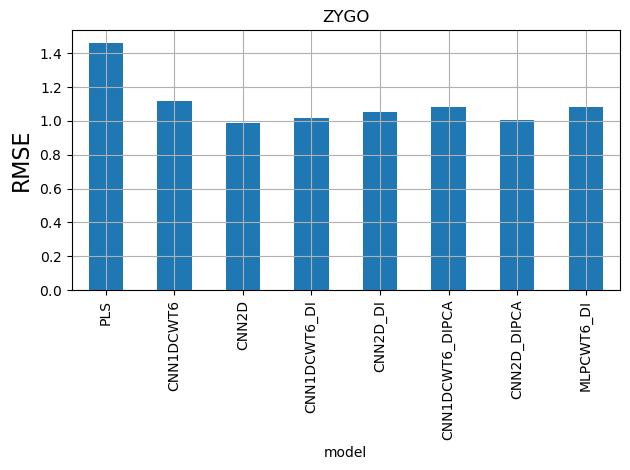

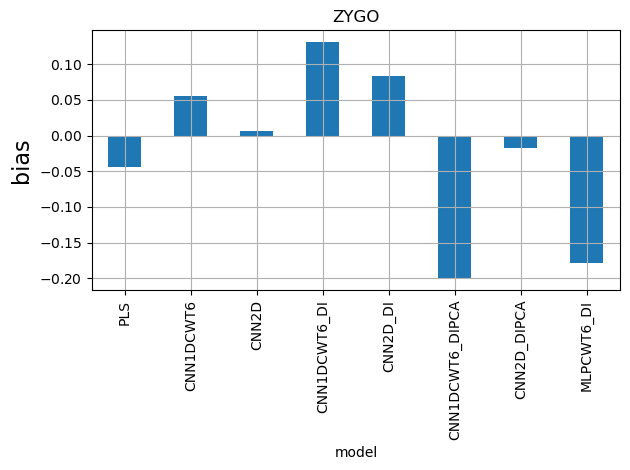

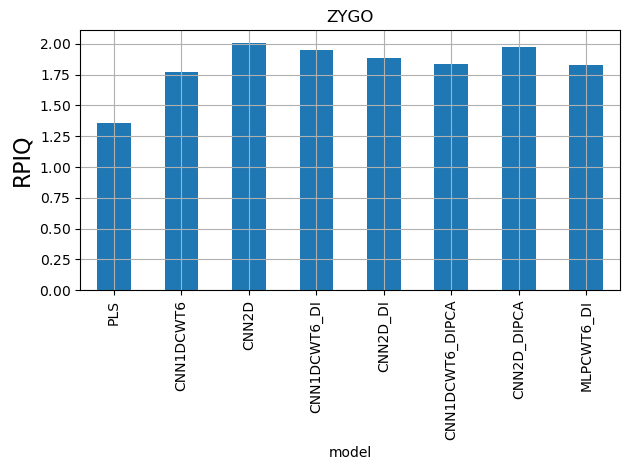

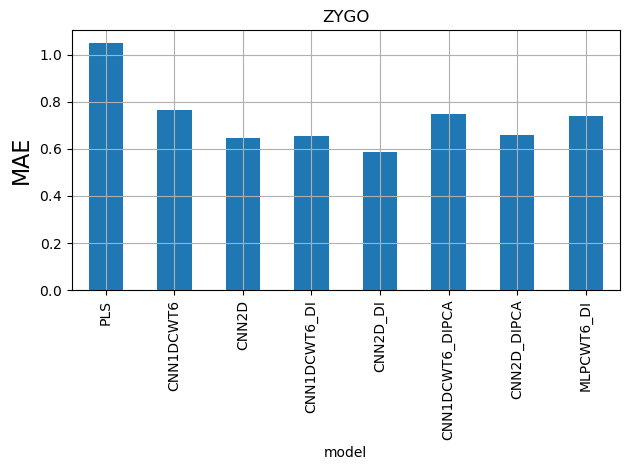

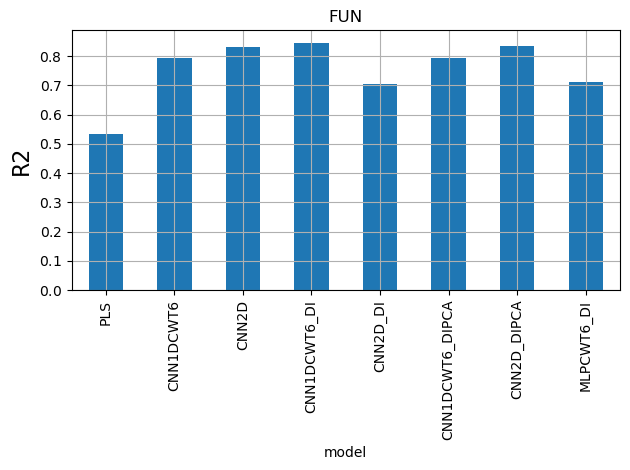

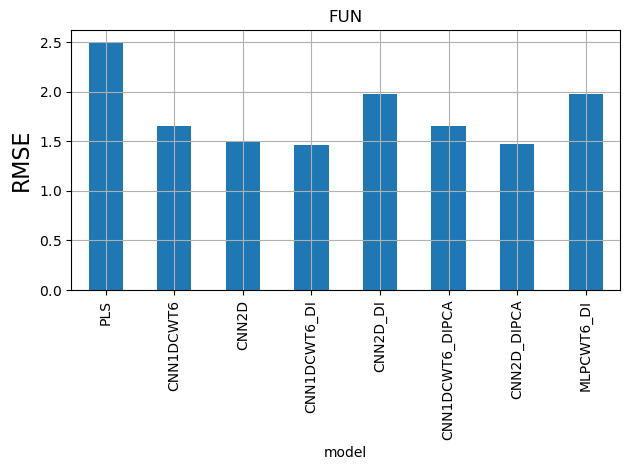

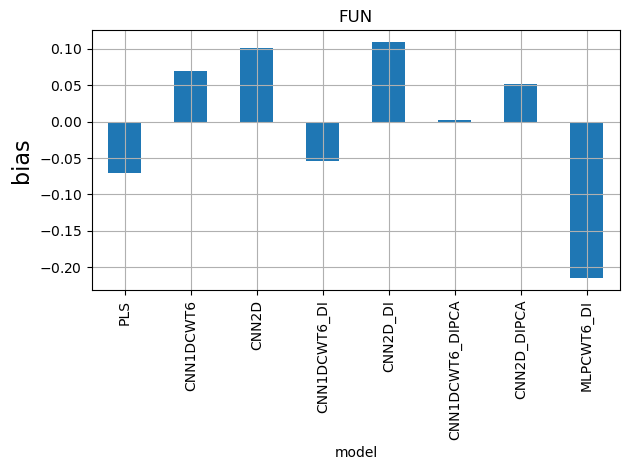

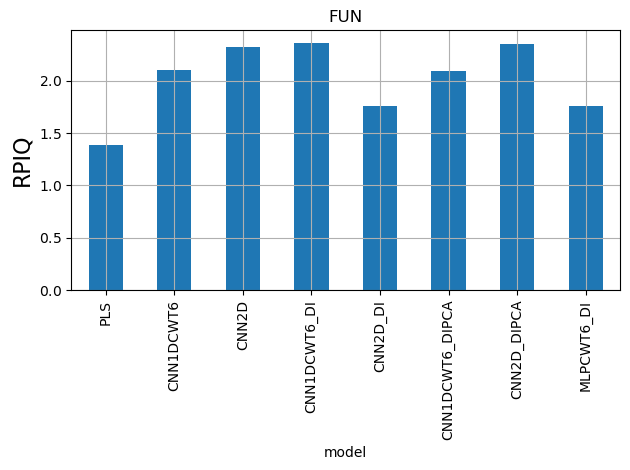

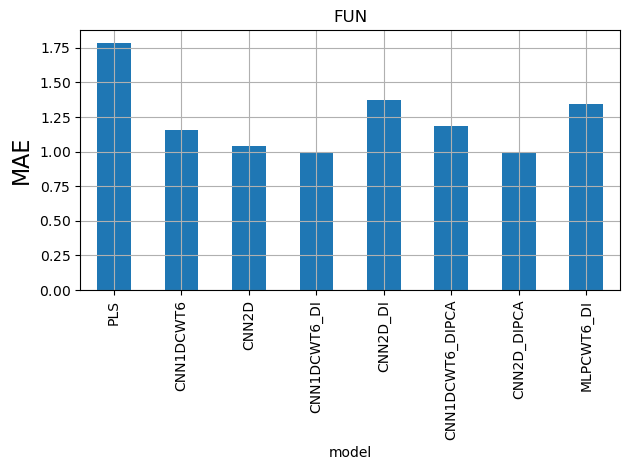

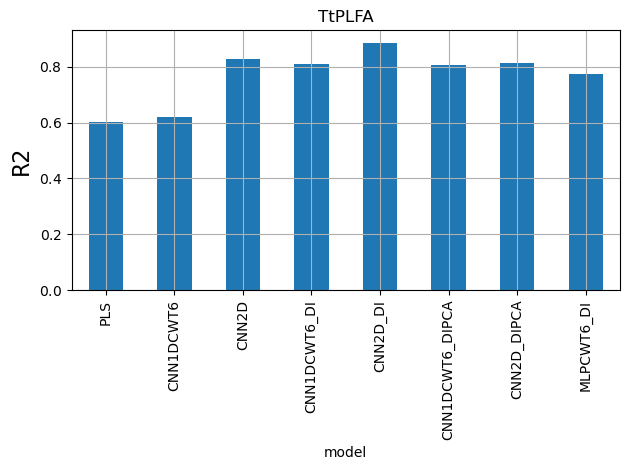

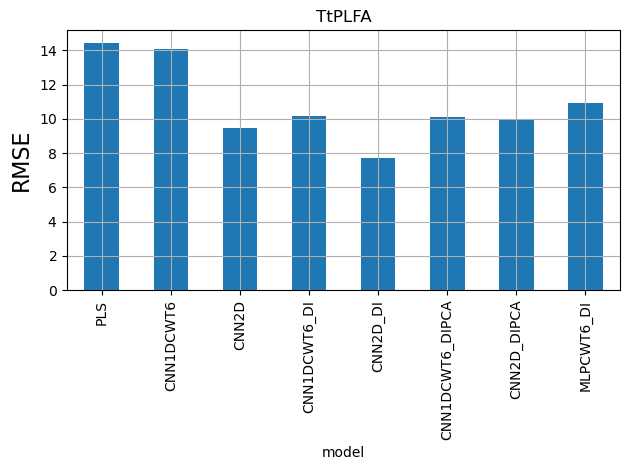

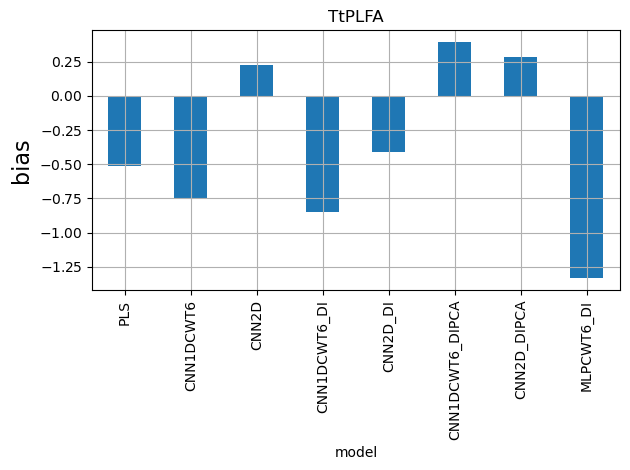

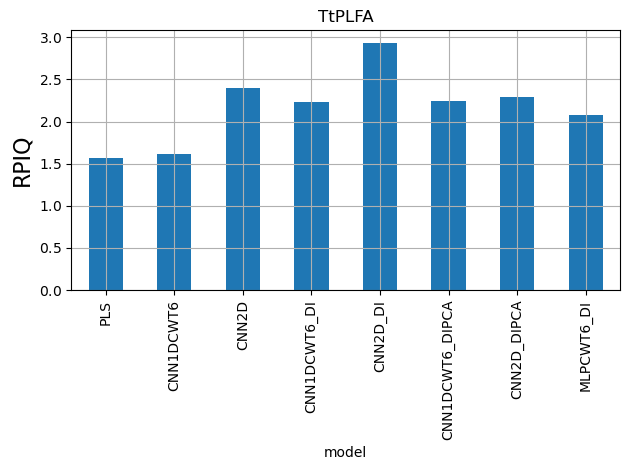

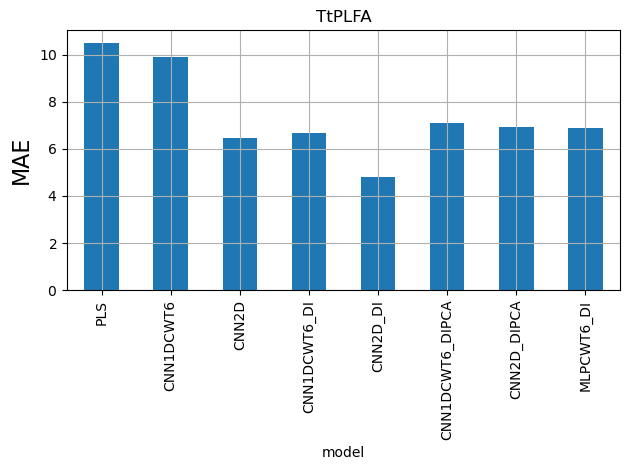

In [51]:
results_lst = []
property_no_data_lst= []
best_results_dict = {}
best_results_pollutant_dict = {}
for property_name in property_name_list:
    property_name_clean= re.sub(r'[^\w\s]', '', property_name)
    try:
        results_df = pd.read_csv(REPORTS_DIRECTORY / f"report_{property_name_clean}.csv", index_col='model')   
        _df = results_df.copy()
        _df['property']= property_name
        results_lst.append(_df)
        for metric in metrics_name_list:

            if metric != 'R2':
                best_value = results_df[metric].min()
                best_model = results_df[metric].idxmin()
            else:
                best_value = results_df[metric].max()
                best_model = results_df[metric].idxmax()

            best_results = best_results_dict.get(metric, [])
            best_results.append({'property': property_name, 'best_value': best_value, 'best_model': best_model})
            best_results_dict[metric]= best_results

            best_results_prop = best_results_pollutant_dict.get(property_name_clean, [])
            best_results_prop.append({'metric': metric, 'best_value': best_value, 'best_model': best_model})
            best_results_pollutant_dict[property_name_clean]= best_results_prop

            ax= results_df[metric].replace([np.inf, -np.inf], np.nan).dropna().plot(grid=True, kind='bar')
            ax.set_ylabel(metric, fontsize=16)
            formatter = mticker.ScalarFormatter(useMathText=True)
            formatter.set_scientific(False)
            ax.yaxis.set_major_formatter(formatter)
            ax.set_title(property_name)
            plt.tight_layout()
            plt.savefig(FIGURES_DIRECTORY / f"{property_name_clean}_{metric}.pdf", dpi=600)
            plt.show()
    except Exception as e:
        print("ERROR::", property_name, e)
        print(results_df[metric])
        property_no_data_lst.append(property_name)


In [52]:
all_results_df = pd.concat(results_lst,axis=0).reset_index()
all_results_df= all_results_df.drop(columns=['MAPE'])
all_results_df

model     R2     RMSE    bias   RPIQ      MAE  \
0                PLS  0.489  300.336   3.843  1.134  238.747   
1          CNN1DCWT6  0.549  279.984  10.576  1.216  207.823   
2              CNN2D  0.660  243.718  13.774  1.397  178.352   
3       CNN1DCWT6_DI  0.777  204.699  -6.539  1.663  128.532   
4           CNN2D_DI  0.659  281.837  15.497  1.208  109.585   
..               ...    ...      ...     ...    ...      ...   
339     CNN1DCWT6_DI  0.810   10.153  -0.847  2.235    6.663   
340         CNN2D_DI  0.886    7.730  -0.408  2.936    4.807   
341  CNN1DCWT6_DIPCA  0.805   10.095   0.392  2.248    7.119   
342      CNN2D_DIPCA  0.813    9.926   0.285  2.287    6.938   
343       MLPCWT6_DI  0.775   10.937  -1.333  2.075    6.876   

                           property  
0    Fungal observed number of OTUs  
1    Fungal observed number of OTUs  
2    Fungal observed number of OTUs  
3    Fungal observed number of OTUs  
4    Fungal observed number of OTUs  
..                              ...  
339                          TtPLFA  
340                          TtPLFA  
341                          TtPLFA  
342                          TtPLFA  
343                          TtPLFA  

[344 rows x 7 columns]

In [53]:

# Transformar el DataFrame para tener dos niveles de columnas
df_pivot = all_results_df.melt(id_vars=["property", "model"], var_name="metric", value_name="value")
df_pivot = df_pivot.pivot(index="property", columns=["model", "metric"], values="value")

df_pivot.columns = pd.MultiIndex.from_tuples(df_pivot.columns, names=["Model", "Metric"])

df_pivot.reset_index(inplace=True)
df_pivot= df_pivot.set_index("property")
print(df_pivot)
df_pivot.to_csv(REPORTS_DIRECTORY / "all_metrics.csv")

Model                                          PLS CNN1DCWT6  CNN2D  \
Metric                                          R2        R2     R2   
property                                                              
ACTI                                         0.527     0.756  0.811   
AMF                                          0.570     0.812  0.816   
BACT                                         0.592     0.692  0.819   
FIR                                          0.513     0.779  0.765   
FUN                                          0.533     0.794  0.833   
Fungal InverseSimpson                        0.212     0.370  0.467   
Fungal Pathotrophs                           0.539     0.011  0.745   
Fungal Pathotrophs-Saprotrophs               0.641     0.821  0.867   
Fungal Pathotrophs-Saprotrophs-Symbiotrophs  0.531     0.773  0.833   
Fungal Pathotrophs-Symbiotrophs              0.105     0.412  0.893   
Fungal Saprotrophs                           0.567     0.801  0.845   
Fungal

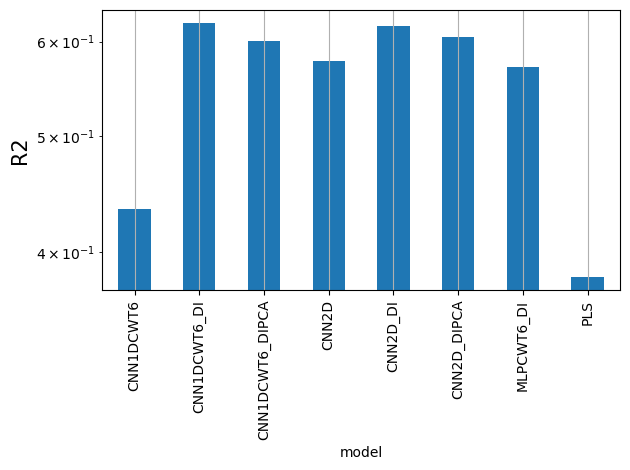

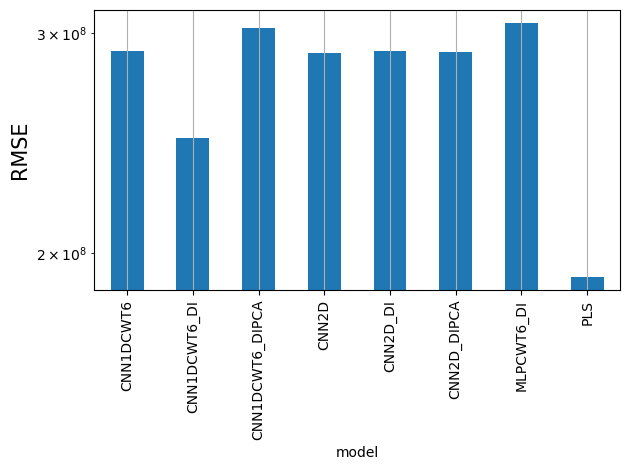

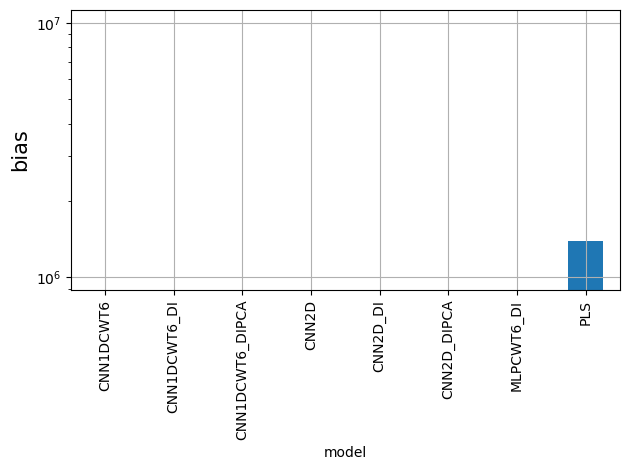

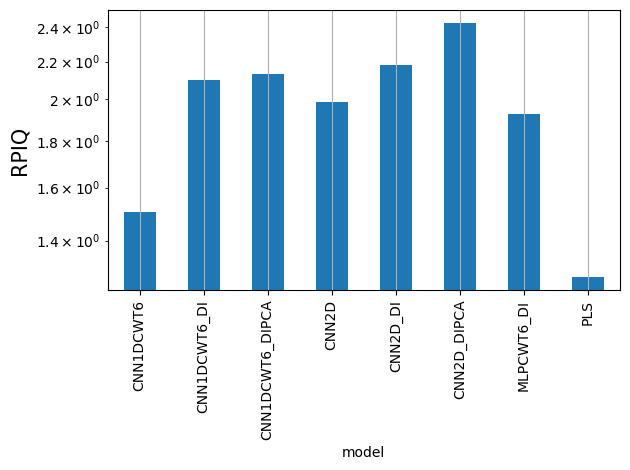

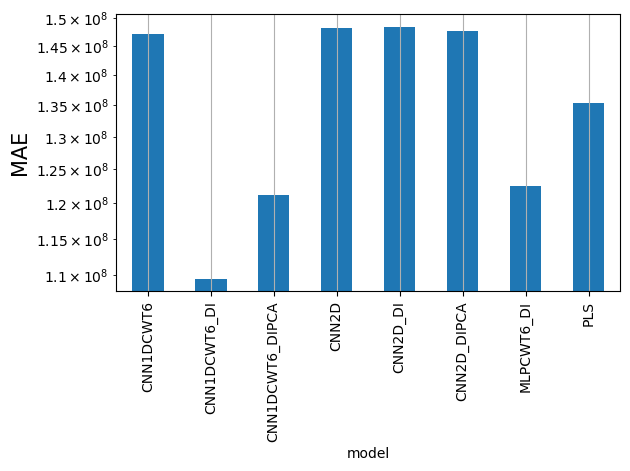

In [54]:
def mean_plot(df, metric):
    clean_df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=[metric])

    _mean= clean_df.groupby('model')[metric].mean()
    _std= clean_df.groupby('model')[metric].std()
    ax=_mean.plot(grid=True, kind='bar')#, yerr=_std)
    ax.set_ylabel(metric, fontsize=15)
    formatter = mticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(False)
    ax.yaxis.set_major_formatter(formatter)
    ax.set_yscale('log')
    plt.tight_layout()
    plt.savefig(FIGURES_DIRECTORY / f"{metric}_mean.pdf", dpi=600)
    plt.show()

for m in metrics_name_list:
    mean_plot(all_results_df, m)


Generate table with best model per property and evaluation metric

In [55]:
for metric, best_result in best_results_dict.items():
    best_result_df= pd.DataFrame(best_result)
    best_result_df= best_result_df.set_index('property')
    best_result_df.to_csv(REPORTS_DIRECTORY / f"best_report_{metric}.csv")

    print("*"* 10, metric, "*"* 10)
    print(best_result_df)
    print("*"* 20)

********** R2 **********
                                             best_value       best_model
property                                                                
Fungal observed number of OTUs                    0.865       MLPCWT6_DI
Fungal chao1                                      0.904       MLPCWT6_DI
Fungal Shannon                                    0.492      CNN2D_DIPCA
Fungal InverseSimpson                             0.548      CNN2D_DIPCA
Fungal yield unknown                              0.870            CNN2D
Fungal Saprotrophs                                0.857     CNN1DCWT6_DI
Fungal Pathotrophs-Saprotrophs                    0.915     CNN1DCWT6_DI
Fungal Pathotrophs-Saprotrophs-Symbiotrophs       0.849     CNN1DCWT6_DI
Fungal Saprotrophs-Symbiotrophs                   0.811         CNN2D_DI
Fungal Symbiotrophs                               0.696            CNN2D
Fungal Pathotrophs                                0.835      CNN2D_DIPCA
Fungal Pathotrophs-Symbiot

In [56]:
for property, best_result in best_results_pollutant_dict.items():
    best_result_df= pd.DataFrame(best_result)
    best_result_df= best_result_df.set_index('metric')
    best_result_df.to_csv(REPORTS_DIRECTORY / f"best_report_{property}.csv")

    print("*"* 10, property, "*"* 10)
    print(best_result_df)
    print("*"* 20)

********** Fungal observed number of OTUs **********
        best_value  best_model
metric                        
R2           0.865  MLPCWT6_DI
RMSE       155.026  MLPCWT6_DI
bias       -22.030  MLPCWT6_DI
RPIQ         1.134         PLS
MAE        107.697  MLPCWT6_DI
********************
********** Fungal chao1 **********
        best_value  best_model
metric                        
R2           0.904  MLPCWT6_DI
RMSE       181.622  MLPCWT6_DI
bias       -24.005  MLPCWT6_DI
RPIQ         1.057    CNN2D_DI
MAE        128.468  MLPCWT6_DI
********************
********** Fungal Shannon **********
        best_value       best_model
metric                             
R2           0.492      CNN2D_DIPCA
RMSE         0.376      CNN2D_DIPCA
bias        -0.167  CNN1DCWT6_DIPCA
RPIQ         0.558     CNN1DCWT6_DI
MAE          0.256      CNN2D_DIPCA
********************
********** Fungal InverseSimpson **********
        best_value   best_model
metric                         
R2           0.548

In [57]:
print("That's all folks!")

That's all folks!
